In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize,
    pop_behavior
)
from bart_single_node_responses import *
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

from diptest import diptest
from scipy.stats import pearsonr
set_rc()

In [4]:
res = pickle.load(open('data/meta_representation_results', 'rb')) # arrays
ares = pickle.load(open('data/meta_rnn_gradients', 'rb')) # dicts
forced_ares = pickle.load(open('data/meta_rnn_forced_gradients', 'rb')) # dicts
node_ares = pickle.load(open('data/meta_single_node_characteristics', 'rb')) # arrays
summary = pickle.load(open('data/meta_summary', 'rb'))
shape = (2, 4, 5, 10)

In [3]:
print('res (general)')
print(np.array(list(res.keys())))
print('ares (activations)')
print(np.array(list(ares.keys())))
print('forced_ares (meta clustering)')
print(np.array(list(forced_ares.keys())))
print('node_ares (single node character)')
print(np.array(list(node_ares.keys())))

res (general)
['last_sizes' 'unpopped_sizes' 'pop_rate' 'rewards' 'values'
 'action_probs' 'all_lens' 'all_num_balloons' 'balloon_steps'
 'button_presses' 'dec_flow_scores' 'iterators_idxs' 'sizes' 'ramp_f1s'
 'ramp_indiv_contribs' 'confidence_scores' 'unconfidence_scores'
 'unconfident_points' 'step_count' 'all_decision_nodes'
 'cluster_regressor_coefs' 'cluster_regressor_scores' 'cluster_ks'
 'pca_regressor_coefs' 'pca_regressor_scores']
ares (activations)
['cluster_activations' 'cluster_labels' 'cluster_orientations'
 'rnn_hx_influences' 'val_grads' 'action_grads' 'all_rnn_hxs'
 'all_ep_lens' 'all_obs' 'rnn_hx_influences2']
forced_ares (meta clustering)
['cluster_activations' 'rnn_hx_influences' 'val_grads' 'action_grads'
 'all_rnn_hxs' 'fixprev_res' 'give_res' 'res' 'all_oriented_cactiv'
 'per_agent_labels' 'per_agent_orientations' 'per_agent_cdists' 'labels'
 'orientations' 'kmeans' 'cdists' 'node_kmeans' 'agent_node_meta_labels'
 'agent_node_meta_orientation' 'per_agent_action_gr

# Summary characteristics

Here we will collect all of the notable summary characteristics that were collected and precompute them into final values

In [25]:
summary = {}

chkidxs = select_chks_by_dimension(with_chk=True, by='first')
idxs = [i[:4] for i in chkidxs]
shape = (2, 4, 5, 10)

# performance
pop_rate = np.zeros(shape)
total_score = np.zeros(shape)
first_chks = np.zeros(shape)
for i in range(len(idxs)):
    pop_rate[idxs[i]] = res['pop_rate'][chkidxs[i]].mean()
    total_score[idxs[i]] = res['last_sizes'][chkidxs[i]].sum()
    first_chks[idxs[i]] = chkidxs[i][4]
summary['pop_rate'] = pop_rate
summary['total_score'] = total_score
summary['first_chks'] = first_chks

# behavior
pop_sloped = np.zeros(shape)
pop_peaked = np.zeros(shape)
bimodal_its = np.zeros(shape)
largest_its = np.zeros(shape)
mean_its = np.zeros(shape)
uncertainty = np.zeros(shape)
for i in range(len(idxs)):
    slope, has_peak = pop_behavior(res['pop_rate'][chkidxs[i]], ret_plot=False)
    pop_sloped[idxs[i]] = slope
    pop_peaked[idxs[i]] = has_peak
    
    its = res['unpopped_sizes'][chkidxs[i]].mean(axis=1)
    m = res['unpopped_sizes'][chkidxs[i]].mean(axis=1)[-1]
    p = res['pop_rate'][chkidxs[i]]
    twophase = np.any(np.diff(its) > 0.15)
    bimodal_its[idxs[i]] = twophase
    largest_its[idxs[i]] = its.max()
    mean_its[idxs[i]] = its.mean()

    lens = res['all_lens'][chkidxs[i]]
    unc = []
    for ep in range(17):
        ap = res['action_probs'][chkidxs[i]][ep, :int(lens[ep])]
        unc.append(ap[ap < 0.5].mean())
    uncertainty[idxs[i]] = np.mean(unc)
summary['pop_sloped'] = pop_sloped
summary['pop_peaked'] = pop_peaked
summary['bimodal_its'] = bimodal_its
summary['largest_its'] = largest_its
summary['mean_its'] = mean_its
summary['uncertainty'] = uncertainty

# exploration strategy
gradual_exploration = np.zeros(shape)
for i in range(len(idxs)):
    diffs = []
    for it in res['unpopped_sizes'][chkidxs[i]]:
        sm_it = np.array(pd.Series(it).ewm(alpha=0.1).mean())
        max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
        diffs.append(max_diff)
    gradual_exploration[idxs[i]] = (np.array(diffs) > 0.2).sum() / 17
summary['gradual_exploration'] = gradual_exploration

# bimodal dynamics
bimodal_rnn = np.zeros(shape)
bimodal_nodes = np.zeros(shape + (64,))
f_bimodal_rnn = np.zeros(shape)
f_bimodal_nodes = np.zeros(shape + (64,))

for idx in idxs:
    rnn_hxs = ares['all_rnn_hxs'][idx]
    data = rnn_hxs.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    rnn_hxs = data_normalized.squeeze().T  # Back to shape [T, 64]
    pca = PCA(n_components=5)
    rnn_pc = pca.fit_transform(rnn_hxs)
    lens = ares['all_ep_lens'][idx]
    ep_rnn = split_by_lens(lens, rnn_pc)

    ep_mean_rnn = [r.mean(axis=0) for r in ep_rnn]
    ep_mean_rnn = np.vstack(ep_mean_rnn)
    ps = []
    for i in range(ep_mean_rnn.shape[1]):
        _, p = diptest(ep_mean_rnn[:, i])
        ps.append(p)
    i = np.argmin(ps)
    comp = np.abs(pca.components_[i])
    perc = np.percentile(comp, 80)
    bimodal_nodes[idx] = (comp > perc) * 1
    bimodal_rnn[idx] = (min(ps) < 0.05) * 1
    
    # forced bimodal rnn
    rnn_hxs = forced_ares['all_rnn_hxs'][idx]
    data = rnn_hxs.T  # change to [64, T]
    scaler = TimeSeriesScalerMeanVariance()
    data_normalized = scaler.fit_transform(data[:, :, np.newaxis])  # Shape becomes [64, T, 1]
    rnn_hxs = data_normalized.squeeze().T  # Back to shape [T, 64]
    pca = PCA(n_components=5)
    rnn_pc = pca.fit_transform(rnn_hxs)
    lens = lens = [len(o) for o in forced_ares['fixprev_res']['obs']]
    ep_rnn = split_by_lens(lens, rnn_pc)

    ep_mean_rnn = [r.mean(axis=0) for r in ep_rnn]
    ep_mean_rnn = np.vstack(ep_mean_rnn)
    ps = []
    for i in range(ep_mean_rnn.shape[1]):
        _, p = diptest(ep_mean_rnn[:, i])
        ps.append(p)
    i = np.argmin(ps)
    comp = np.abs(pca.components_[i])
    perc = np.percentile(comp, 80)
    f_bimodal_nodes[idx] = (comp > perc) * 1
    f_bimodal_rnn[idx] = (min(ps) < 0.05) * 1
summary['bimodal_rnn'] = bimodal_rnn
summary['bimodal_nodes'] = bimodal_nodes

# policy/value cluster classifications
val_scores = np.zeros(shape + (64,)) # score
pol_scores = np.zeros(shape + (64,))
in_val_cluster = np.zeros(shape + (64,)) # 0/1
in_pol_cluster = np.zeros(shape + (64,))
for idx in idxs:
    labels = ares['cluster_labels'][idx]
    vscore, pscore = get_val_and_action_scores(labels=ares['cluster_labels'][idx],
                                                       val_grads=ares['val_grads'][idx],
                                                       act_grads=ares['action_grads'][idx])
    vscore, pscore = np.array(vscore), np.array(pscore)
    vscore[vscore == None] = 0
    pscore[pscore == None] = 0
    k = labels.max() + 1
    for i in range(k):
        val_scores[idx][labels == i] = vscore[i]
        pol_scores[idx][labels == i] = pscore[i]
        if vscore[i] > 0:
            in_val_cluster[idx][labels == i] = 1
        if pscore[i] > 0:
            in_pol_cluster[idx][labels == i] = 1
summary['val_scores'] = val_scores
summary['pol_scores'] = pol_scores
summary['in_val_cluster'] = in_val_cluster
summary['in_pol_cluster'] = in_pol_cluster

# decision nodes
# decision_node = np.zeros(shape + (64,))
# for i in range(len(idxs)):
#     decision_node[idxs[i]] = (res['all_decision_nodes'][chkidxs[0]].mean(axis=0) > 0.5) * 1
# summary['decision_node'] = decision_node
summary['decision_nodes'] = ares['decision_nodes']


# activating cluster classifications
node_meta_labels = np.zeros(shape + (64,))
for idx in idxs:
    node_meta_labels[idx] = forced_ares['agent_node_meta_labels'][idx]
summary['node_meta_labels'] = node_meta_labels

# individual node stimuli responses
linear_response = np.zeros(shape + (64,))
quadratic_response = np.zeros(shape + (64,))
left_sensitive = np.zeros(shape + (64,))
right_sensitive = np.zeros(shape + (64,))
lr_sensitive = np.zeros(shape + (64,))
turning_point = np.zeros(shape + (64,))
slow_size_recov = np.zeros(shape + (64,))
slow_pop_recov = np.zeros(shape + (64,))
size_resp_reversal = np.zeros(shape + (64,))
for idx in idxs:
    linear_response[idx] = node_ares['response_types'][idx] == 1
    quadratic_response[idx] = node_ares['response_types'][idx] == 2
    left_sensitive[idx] = node_ares['lr_sens_bias'][idx] == -1
    right_sensitive[idx] = node_ares['lr_sens_bias'][idx] == 1
    lr_sensitive[idx] = node_ares['lr_sens_bias'][idx] != 0
    turning_point[idx] = node_ares['turning_points'][idx]
    slow_size_recov[idx] = node_ares['size_recoveries'][idx] >= 2
    slow_pop_recov[idx] = node_ares['pop_recoveries'][idx] >= 2
    size_resp_reversal[idx] = node_ares['reversals'][idx] >= 0
summary['linear_response'] = linear_response
summary['quadratic_response'] = quadratic_response
summary['left_sensitive'] = left_sensitive
summary['right_sensitive'] = right_sensitive
summary['lr_sensitive'] = lr_sensitive
summary['turning_point'] = turning_point
summary['slow_size_recov'] = slow_size_recov
summary['slow_pop_recov'] = slow_pop_recov
summary['size_resp_reversal'] = size_resp_reversal

# agent cluster frequency meta clustering
#  find agent types in terms of frequencies that RNN clusters appear in agents
k = 3
idxs = select_chks_by_dimension(i=range(4))
labels = np.zeros(shape + (k,))
for idx in idxs:
    for c in range(k):
        labels[idx][c] = (np.array(forced_ares['agent_node_meta_labels'][idx]) == c).sum() / 64
clusters = labels.reshape(-1, k)
kmeans = KMeans(n_clusters=k, random_state=0)
agent_labels = kmeans.fit_predict(clusters)
agent_labels = agent_labels.reshape(shape)
summary['agent_types'] = agent_labels

pickle.dump(summary, open('data/meta_summary', 'wb'))

c:\Users\14and\Desktop\Work\github\bart_ppo\write_and_test\bart_representation_analysis.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  


In [26]:
summary = pickle.load(open('data/meta_summary', 'rb'))

chkidxs = select_chks_by_dimension(with_chk=True, by='first')
idxs = [i[:4] for i in chkidxs]
shape = (2, 4, 5, 10)
# human tuned scores - use balloon sizes 0.25, 0.45, 0.7
#  unsure but it seems like human balloon sizes are around 1500, 2500, 4000
#  conservatively could consider them 2000, 3000, 4500
human_mus = [1, 5, 10]
pop_rate = np.zeros(shape)
total_score = np.zeros(shape)
mean_its = np.zeros(shape)
for i in range(len(idxs)):
    pop_rate[idxs[i]] = res['pop_rate'][chkidxs[i]][human_mus].mean()
    total_score[idxs[i]] = res['last_sizes'][chkidxs[i]][human_mus].sum()
    its = res['unpopped_sizes'][chkidxs[i]][human_mus].mean(axis=1)
    mean_its[idxs[i]] = its.mean()
summary['human_pop_rate'] = pop_rate
summary['human_total_score'] = total_score
summary['human_mean_its'] = mean_its

# human versions of exploration and bimodal ITs
exploration_scores = np.zeros(shape)
bimodal_its = np.zeros(shape)
for i in range(len(idxs)):
    unpopped = res['unpopped_sizes'][chkidxs[i]][human_mus]
    expl = 0
    for it in unpopped:
        sm_it = np.array(pd.Series(it).ewm(alpha=0.1).mean())[10:]
        max_diff = np.max(np.tril(sm_it.reshape(-1, 1) - sm_it))
        expl += max_diff
    gradual_exploration = expl / 3
    
    diff = np.diff(np.mean(unpopped, axis=1))
    if (diff[0] < diff[1]*0.35 or diff[1] < diff[0]*0.35) and \
        (diff[0] > 0 and diff[1] > 0):
        simple_bimodal = True
    else:
        simple_bimodal = False
    exploration_scores[idxs[i]] = gradual_exploration
    bimodal_its[idxs[i]] = simple_bimodal * 1
    # print(bimodal_its)
summary['human_exploration'] = exploration_scores > 0.08
summary['human_bimodal_its'] = bimodal_its

pickle.dump(summary, open('data/meta_summary', 'wb'))

In [21]:
print(((summary['human_bimodal_its'] == 1) & (summary['bimodal_its'] == 1)).sum())
print(summary['human_bimodal_its'].sum())
print(summary['bimodal_its'].sum())

38
98.0
103.0


In [ ]:
print(((summary['human_exploration'] > 0.08) & (summary['gradual_exploration'] > 0.3)).sum())
print((summary['human_exploration'] > 0.08).sum())
print((summary['gradual_exploration'] > 0.3).sum())

32
49
89


# Distributions across agents

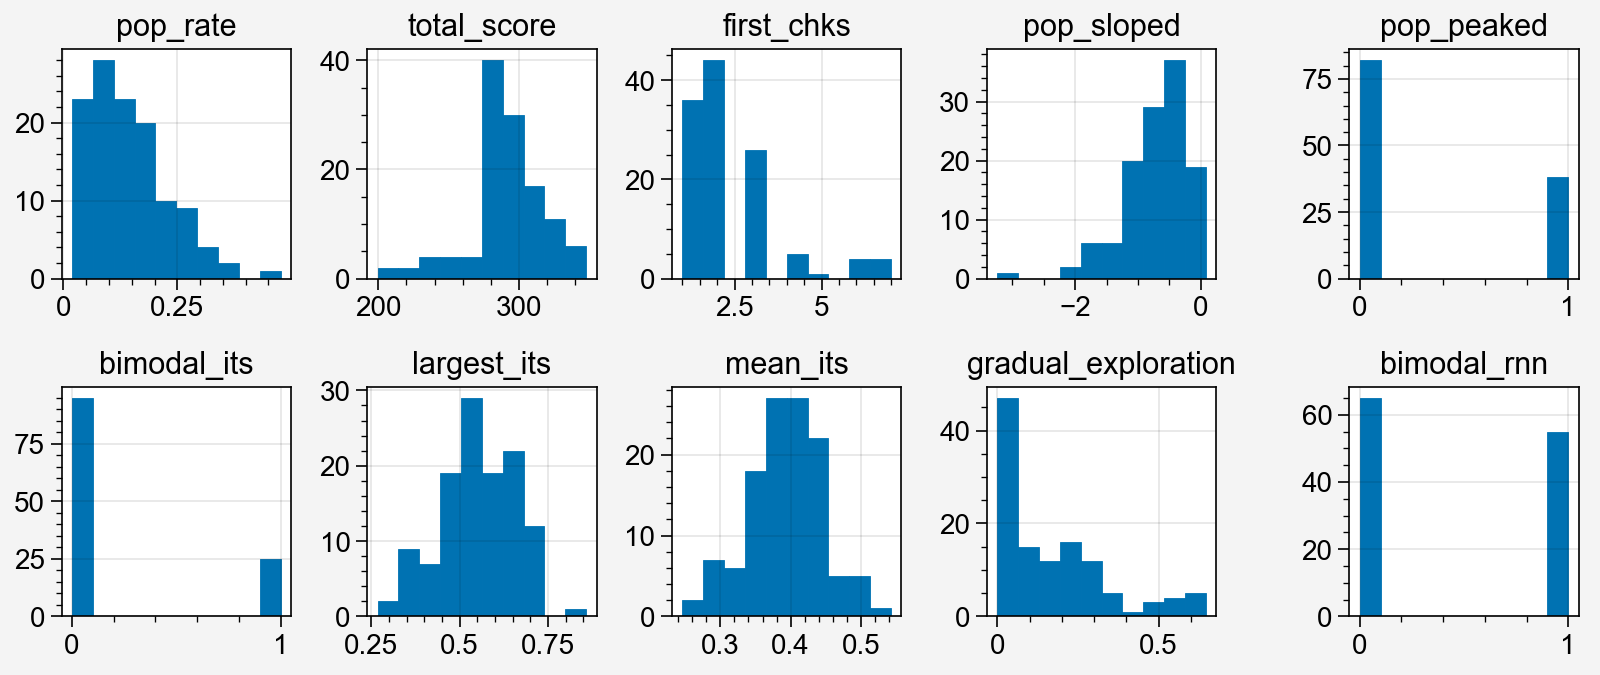

In [92]:
agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
              'pop_peaked', 'bimodal_its', 'largest_its', 'mean_its', 'gradual_exploration',
              'bimodal_rnn']

fig, ax = pplt.subplots(ncols=5, nrows=2, sharex=False, sharey=False,
                        figwidth=8)
for i, key in enumerate(agent_keys):
    ax[i].hist(summary[key].reshape(-1))
    ax[i].format(title=key)

# General correlations

## Agent characteristics

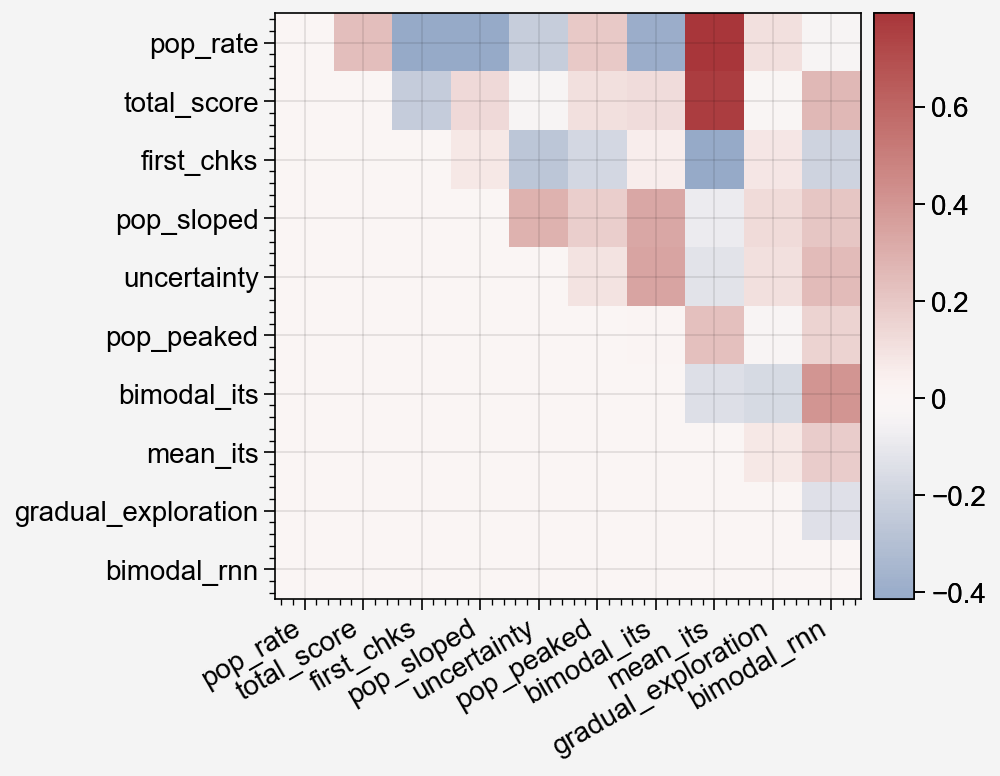

In [10]:
agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped', 'uncertainty',
              'pop_peaked', 'bimodal_its', 'mean_its', 'gradual_exploration',
              'bimodal_rnn']

n = len(agent_keys)
corr = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i >= j:
            continue
        x = summary[agent_keys[i]].reshape(-1)
        y = summary[agent_keys[j]].reshape(-1)
        r = np.corrcoef(x, y)[0, 1]
        corr[i, j] = r
        
fig, ax = pplt.subplots(figwidth=5)
cm = ax.imshow(corr, cmap='vlag')
ax.colorbar(cm)
ax.format(xlocator=range(n), xformatter=agent_keys, xrotation=30,
          ylocator=range(n), yformatter=agent_keys)


In [39]:
from scipy.stats import t

def calculate_p_values(corr_matrix, sample_size):
    t_matrix = corr_matrix * np.sqrt(sample_size - 2) / np.sqrt(1 - corr_matrix**2)
    p_values = 2 * (1 - t.cdf(np.abs(t_matrix), df=sample_size - 2))  # Two-tailed test
    return p_values

sample_size = 400
p_values_matrix = calculate_p_values(corr, sample_size)
alpha = 0.01
significant_matrix = (p_values_matrix < alpha) & (np.abs(corr) > 0.3)

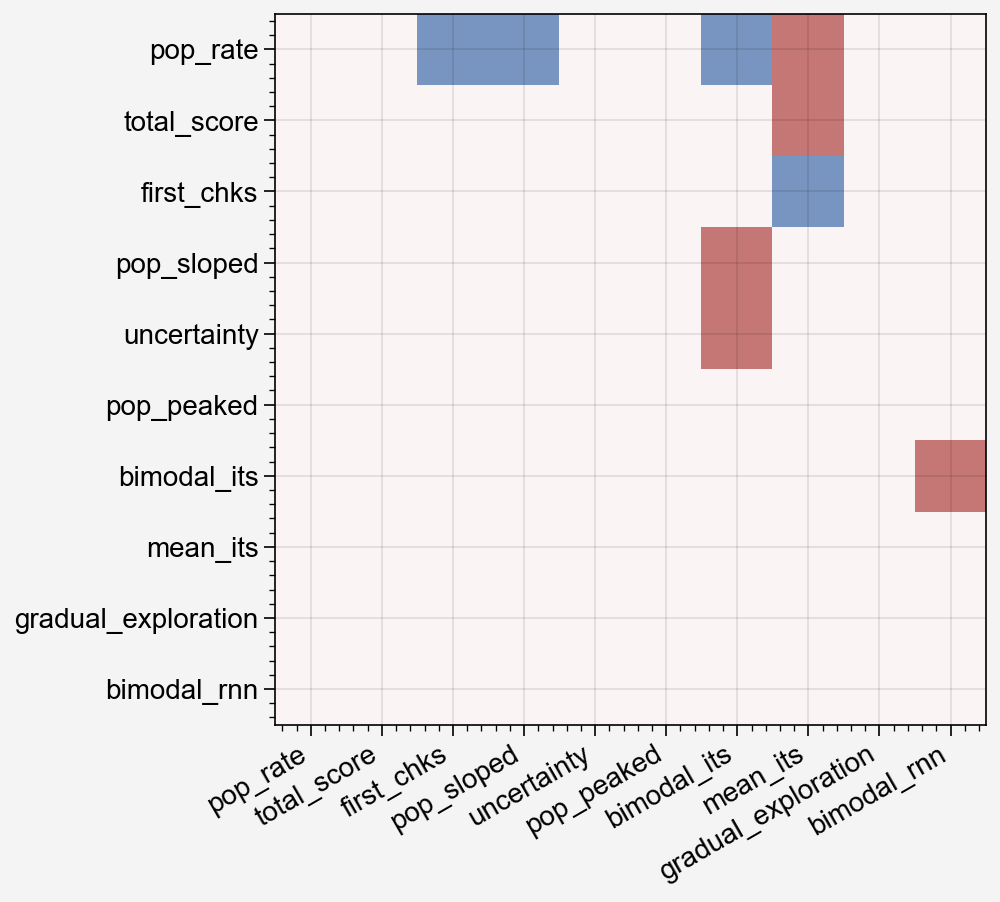

In [40]:
fig, ax = pplt.subplots(figwidth=5)
ax.imshow(significant_matrix*np.sign(corr), vmin=-1.5, vmax=1.5, cmap='vlag')
ax.format(xlocator=range(n), xformatter=agent_keys, xrotation=30,
          ylocator=range(n), yformatter=agent_keys)

## Node/agent cross

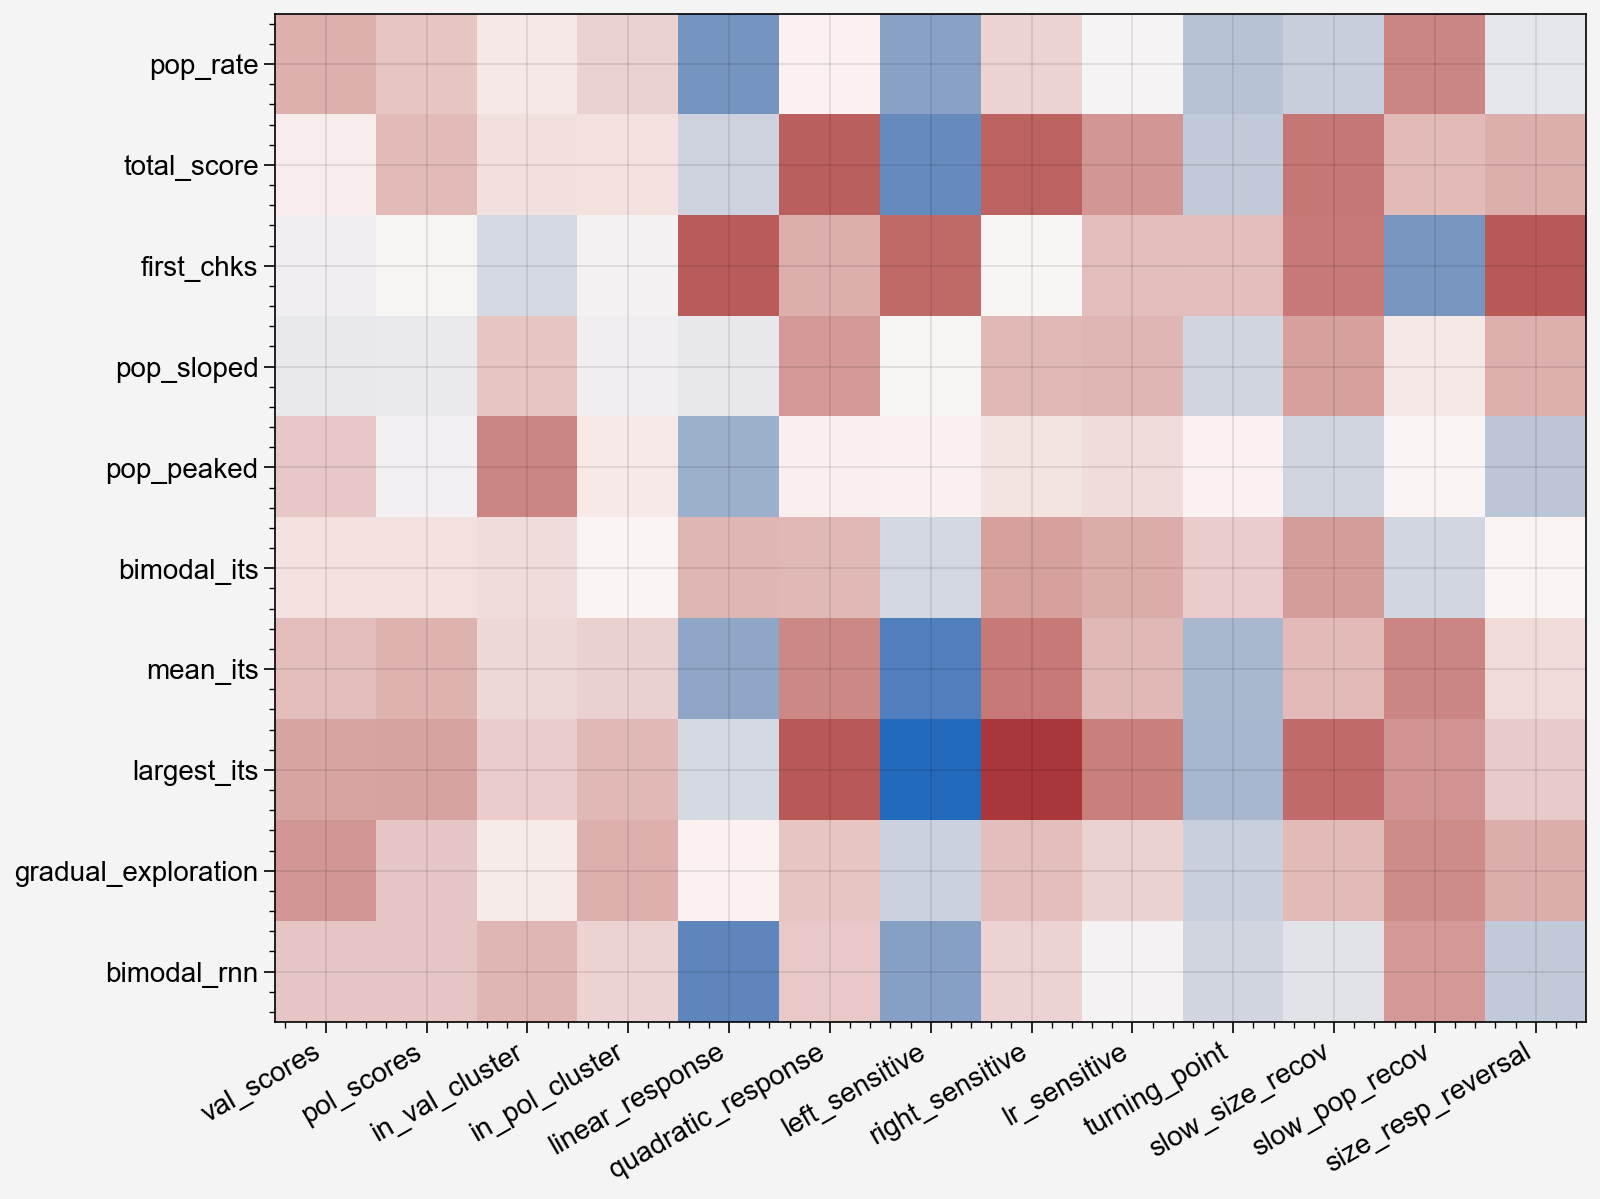

In [26]:
agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
              'pop_peaked', 'bimodal_its', 'mean_its', 'largest_its', 'gradual_exploration',
              'bimodal_rnn']

node_reduce = {
    'val_scores': 'sum',
    'pol_scores': 'sum',
    'in_val_cluster': 'sum',
    'in_pol_cluster': 'sum',
    'linear_response': 'sum',
    'quadratic_response': 'sum',
    'left_sensitive': 'sum',
    'right_sensitive': 'sum',
    'lr_sensitive': 'sum',
    'turning_point': 'sum',
    'slow_size_recov': 'sum',
    'slow_pop_recov': 'sum',
    'size_resp_reversal': 'sum',
}

corr = np.zeros((len(agent_keys), len(node_reduce)))
for i, k1 in enumerate(agent_keys):
    for j, k2 in enumerate(node_reduce):
        x = summary[k1].reshape(-1)
        y = summary[k2].mean(axis=4).reshape(-1)
        # (_, _), r2 = linear_best_fit(x, y)
        # corr[i, j] = r2
        r = np.corrcoef(x, y)[0, 1]
        corr[i, j] = r
fig, ax = pplt.subplots(figwidth=8)
ax.imshow(corr, cmap='vlag')
ax.format(ylocator=range(len(agent_keys)), yformatter=agent_keys,
          xlocator=range(len(node_reduce)), xformatter=list(node_reduce.keys()),
          xrotation=30)

(array([ 4.,  6.,  5., 12., 15., 26., 12., 11.,  9.,  4.]),
 array([-0.39575867, -0.31740109, -0.23904351, -0.16068592, -0.08232834,
        -0.00397075,  0.07438683,  0.15274441,  0.231102  ,  0.30945958,
         0.38781716]),
 <BarContainer object of 10 artists>)

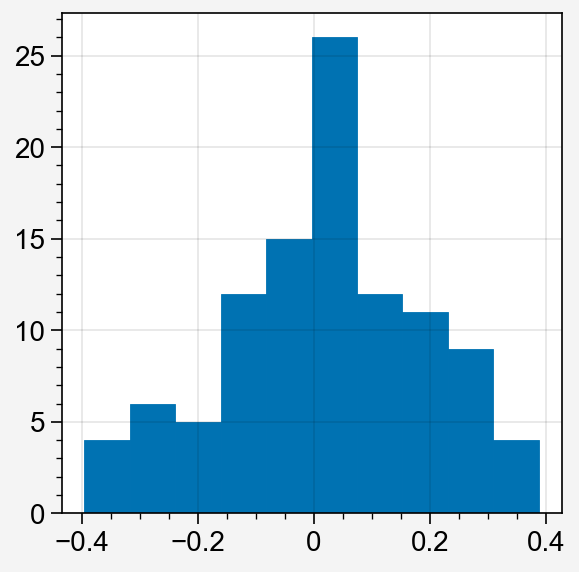

In [136]:
fig, ax = pplt.subplots()
ax.hist(corr.reshape(-1))

In [20]:
from scipy.stats import t
sample_size = 120

# Function to calculate p-values for a correlation matrix
def calculate_p_values(corr_matrix, sample_size):
    t_matrix = corr_matrix * np.sqrt(sample_size - 2) / np.sqrt(1 - corr_matrix**2)
    p_values = 2 * (1 - t.cdf(np.abs(t_matrix), df=sample_size - 2))  # Two-tailed test
    return p_values

# Calculate p-values
p_values_matrix = calculate_p_values(corr, sample_size)

# Define a significance threshold (e.g., alpha = 0.05)
alpha = 0.05
significant_matrix = p_values_matrix < alpha

# Output results
p_values_matrix, significant_matrix

(array([[7.39832729e-02, 2.00375181e-01, 6.43501922e-01, 3.16546055e-01,
         9.73953511e-04, 8.29850627e-01, 4.31751420e-03, 3.30848904e-01,
         8.43882290e-01, 8.94339106e-02, 1.81278216e-01, 3.63959411e-03,
         5.14995670e-01],
        [7.51001426e-01, 1.29736164e-01, 5.15580173e-01, 5.32778024e-01,
         2.17685267e-01, 8.47202103e-05, 2.04071467e-04, 1.10917035e-04,
         1.44403189e-02, 1.32819533e-01, 1.07098589e-03, 1.30299299e-01,
         6.68414769e-02],
        [6.89420127e-01, 8.60072044e-01, 2.98906243e-01, 7.56321071e-01,
         4.95014794e-05, 6.95983603e-02, 2.80523901e-04, 9.51459620e-01,
         1.34679361e-01, 1.50644228e-01, 1.13742880e-03, 1.13840174e-03,
         3.85982704e-05],
        [5.61713323e-01, 5.77541901e-01, 1.96611864e-01, 6.85893030e-01,
         5.33197765e-01, 1.73987895e-02, 8.54927095e-01, 1.10155891e-01,
         1.03890895e-01, 2.52068761e-01, 2.61030531e-02, 6.45723153e-01,
         7.57241346e-02],
        [2.24661963e

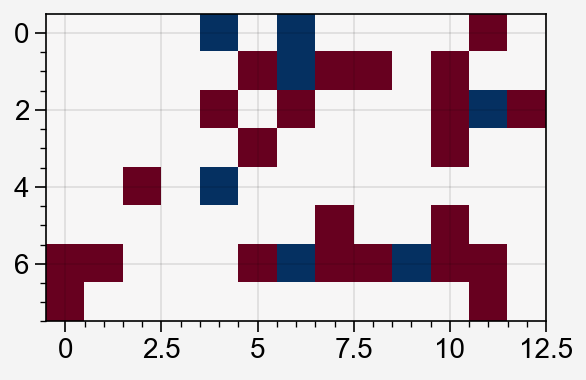

In [21]:
fig, ax = pplt.subplots()
ax.imshow(significant_matrix*np.sign(corr))

In [ ]:
agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
              'pop_peaked', 'bimodal_its', 'largest_its', 'gradual_exploration']

node_reduce = {
    'val_scores': 'sum',
    'pol_scores': 'sum',
    'in_val_cluster': 'sum',
    'in_pol_cluster': 'sum',
    'linear_response': 'sum',
    'quadratic_response': 'sum',
    'left_sensitive': 'sum',
    'right_sensitive': 'sum',
    'lr_sensitive': 'sum',
    'turning_point': 'sum',
    'slow_size_recov': 'sum',
    'slow_pop_recov': 'sum',
    'size_resp_reversal': 'sum',
}

corr = np.zeros((len(agent_keys), len(node_reduce)))
for i, k1 in enumerate(agent_keys):
    for j, k2 in enumerate(node_reduce):
        x = summary[k1].reshape(-1)
        y = summary[k2].mean(axis=4).reshape(-1)
        # (_, _), r2 = linear_best_fit(x, y)
        # corr[i, j] = r2
        r = np.corrcoef(x, y)[0, 1]
        corr[i, j] = r
fig, ax = pplt.subplots(figwidth=8)
ax.imshow(corr, cmap='vlag')
ax.format(ylocator=range(len(agent_keys)), yformatter=agent_keys,
          xlocator=range(len(node_reduce)), xformatter=list(node_reduce.keys()),
          xrotation=30)

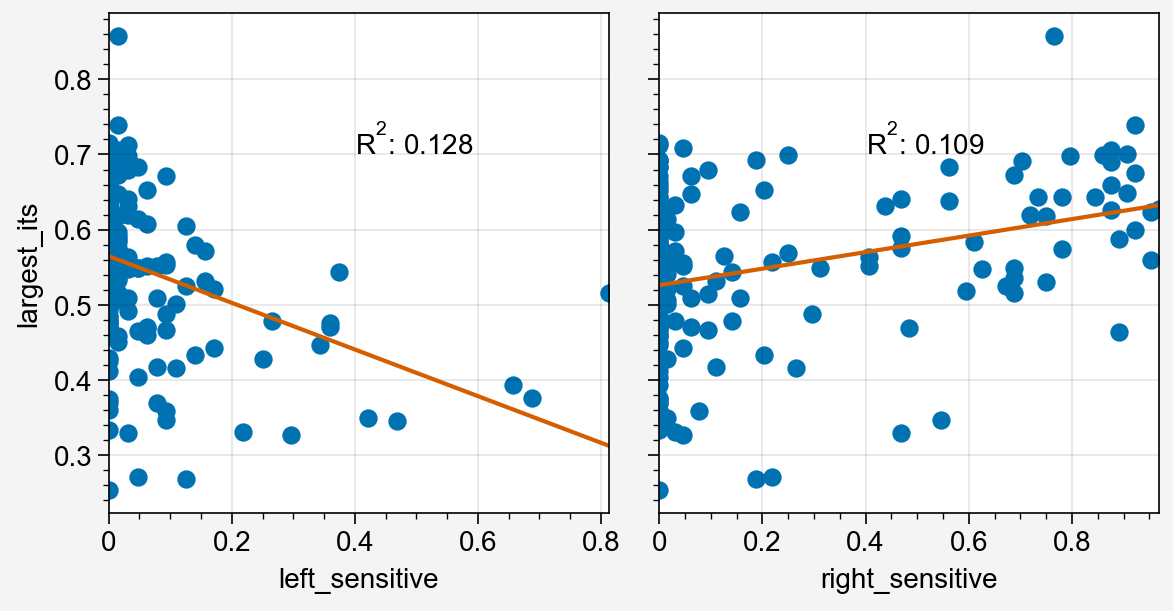

In [52]:
x_keys = ['left_sensitive', 'right_sensitive']
y_key = 'largest_its'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.7, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

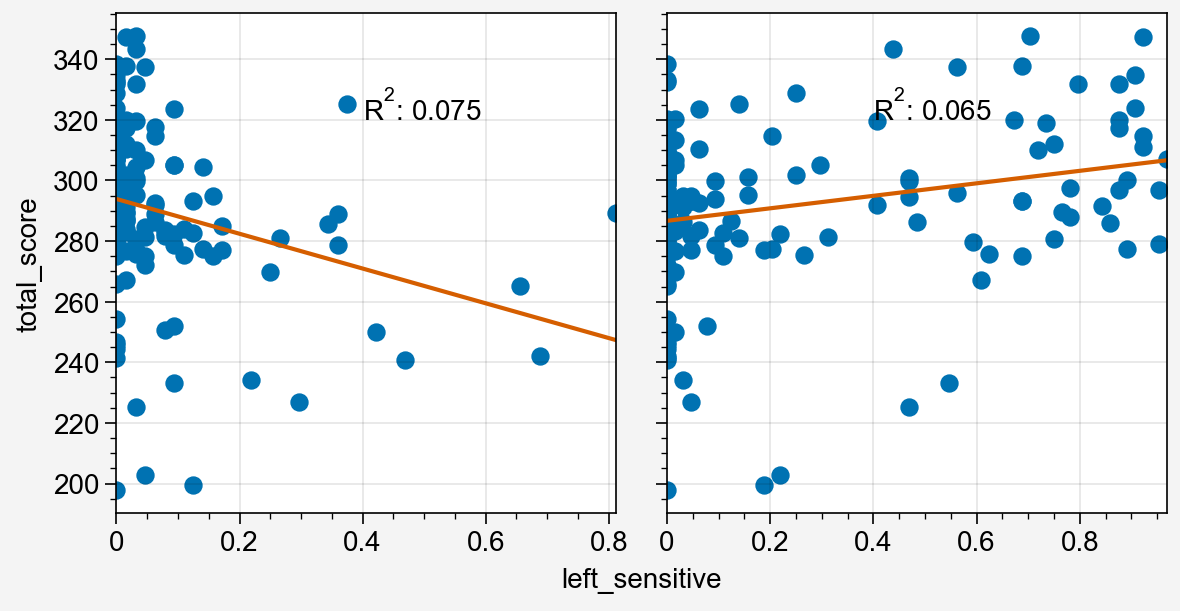

In [51]:
x_keys = ['left_sensitive', 'right_sensitive']
y_key = 'total_score'
fig, ax = pplt.subplots(ncols=2)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 320, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

R2: 0.079


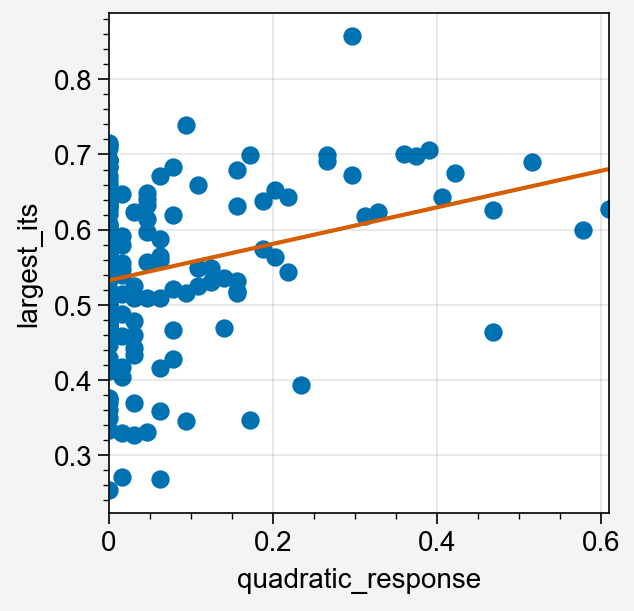

In [82]:
x_key = 'quadratic_response'
y_key = 'largest_its'

x = summary[x_key].mean(axis=4).reshape(-1)
y = summary[y_key].reshape(-1)

fig, ax = pplt.subplots()
ax.scatter(x, y)
(m, b), r2 = linear_best_fit(x, y)
x = np.array([x.min(), x.max()])
ax.plot(x, m*x+b)
ax.format(xlabel=x_key, ylabel=y_key)
print(f'R2: {r2:.3f}')

## Node characteristics

In [7]:
node_keys = [ #'val_scores', 'pol_scores', 
             'in_val_cluster', 'in_pol_cluster',
             'linear_response', 'quadratic_response', 'left_sensitive', 'right_sensitive', 
             'turning_point', 'slow_size_recov', 'slow_pop_recov', 'size_resp_reversal',
             'decision_node', 'bimodal_nodes']

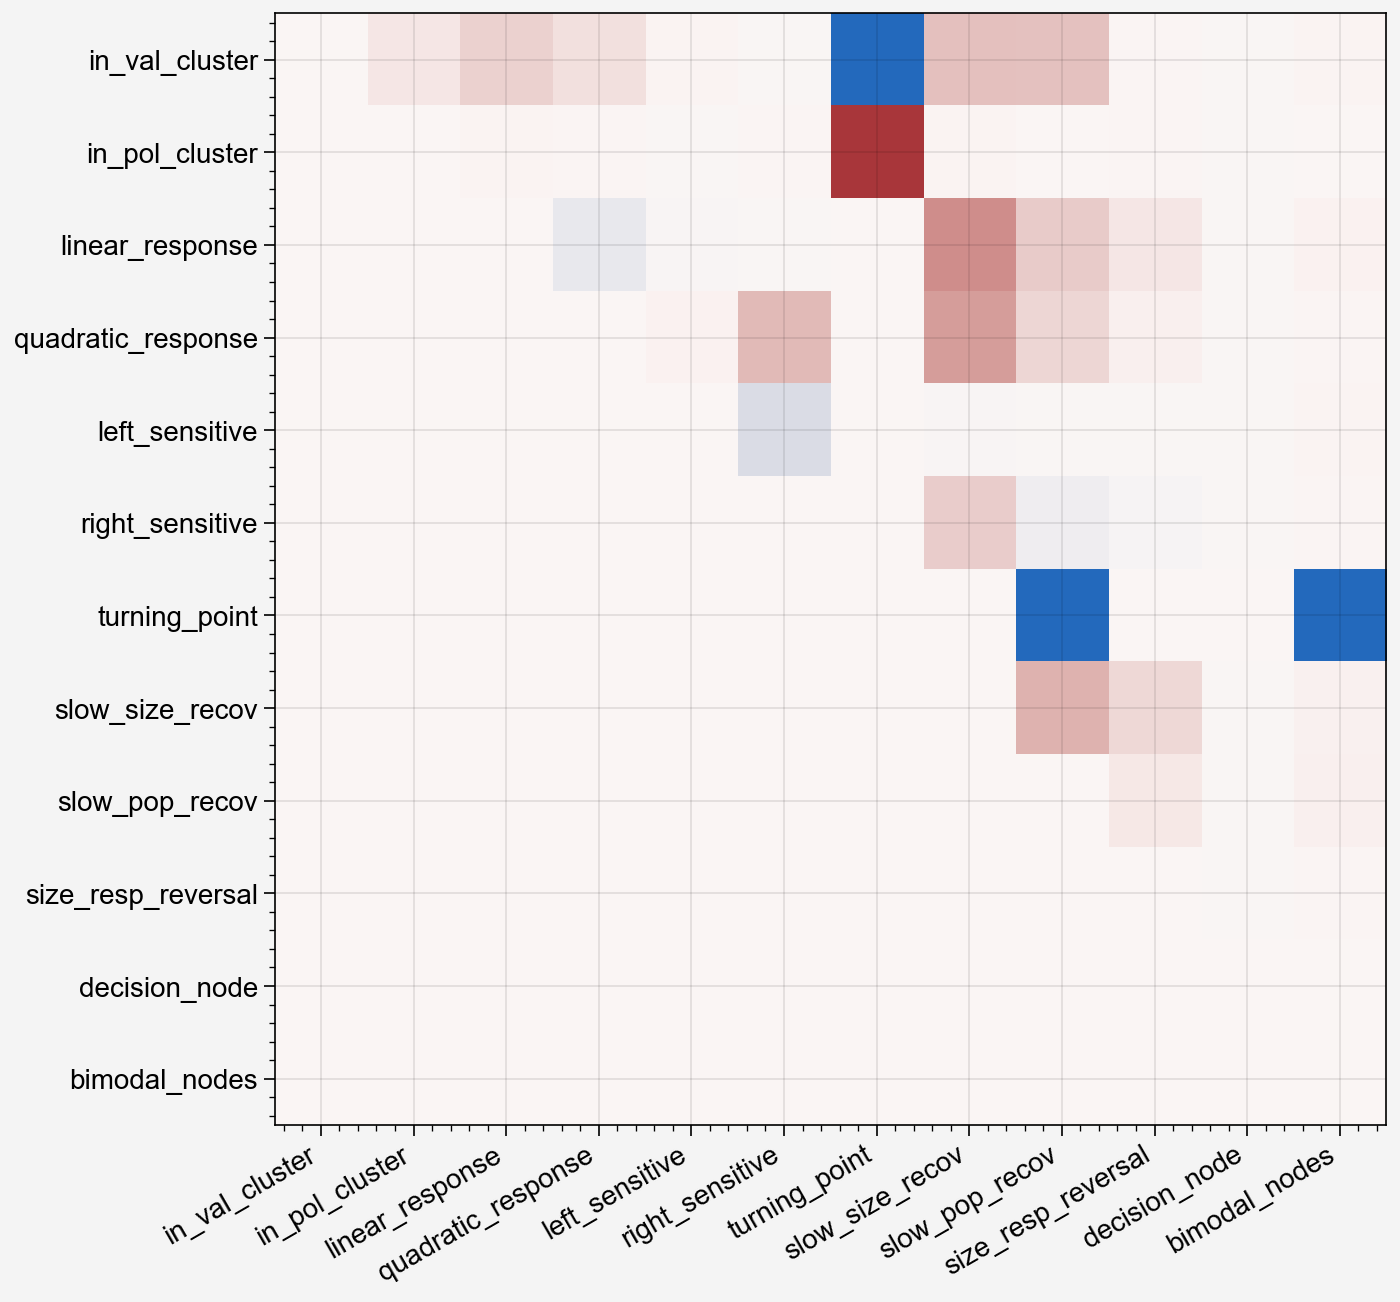

In [8]:
from scipy.stats import chi2_contingency

n = len(node_keys)
total = 11520

corr = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i >= j:
            continue
        x = summary[node_keys[i]].reshape(-1)
        y = summary[node_keys[j]].reshape(-1)
        cont = pd.crosstab(x, y)
        chi2, p, _, _ = chi2_contingency(cont)
        corr[i, j] = chi2 / total

        cont = pd.crosstab(x, y).values
        n_11 = cont[1, 1]
        n_10 = cont[1, 0]
        n_01 = cont[0, 1]
        n_00 = cont[0, 0]

        numerator = n_11 * n_00 - n_10 * n_01
        denominator = np.sqrt((n_11 + n_10) * (n_01 + n_00) * (n_11 + n_01) * (n_10 + n_00))
        if denominator == 0:
            corr[i, j] = 0
        else:
            corr[i, j] = numerator / denominator
fig, ax = pplt.subplots(figwidth=7)
ax.imshow(corr, cmap='vlag')
ax.format(ylocator=range(len(node_keys)), yformatter=node_keys,
          xlocator=range(len(node_keys)), xformatter=list(node_keys),
          xrotation=30)

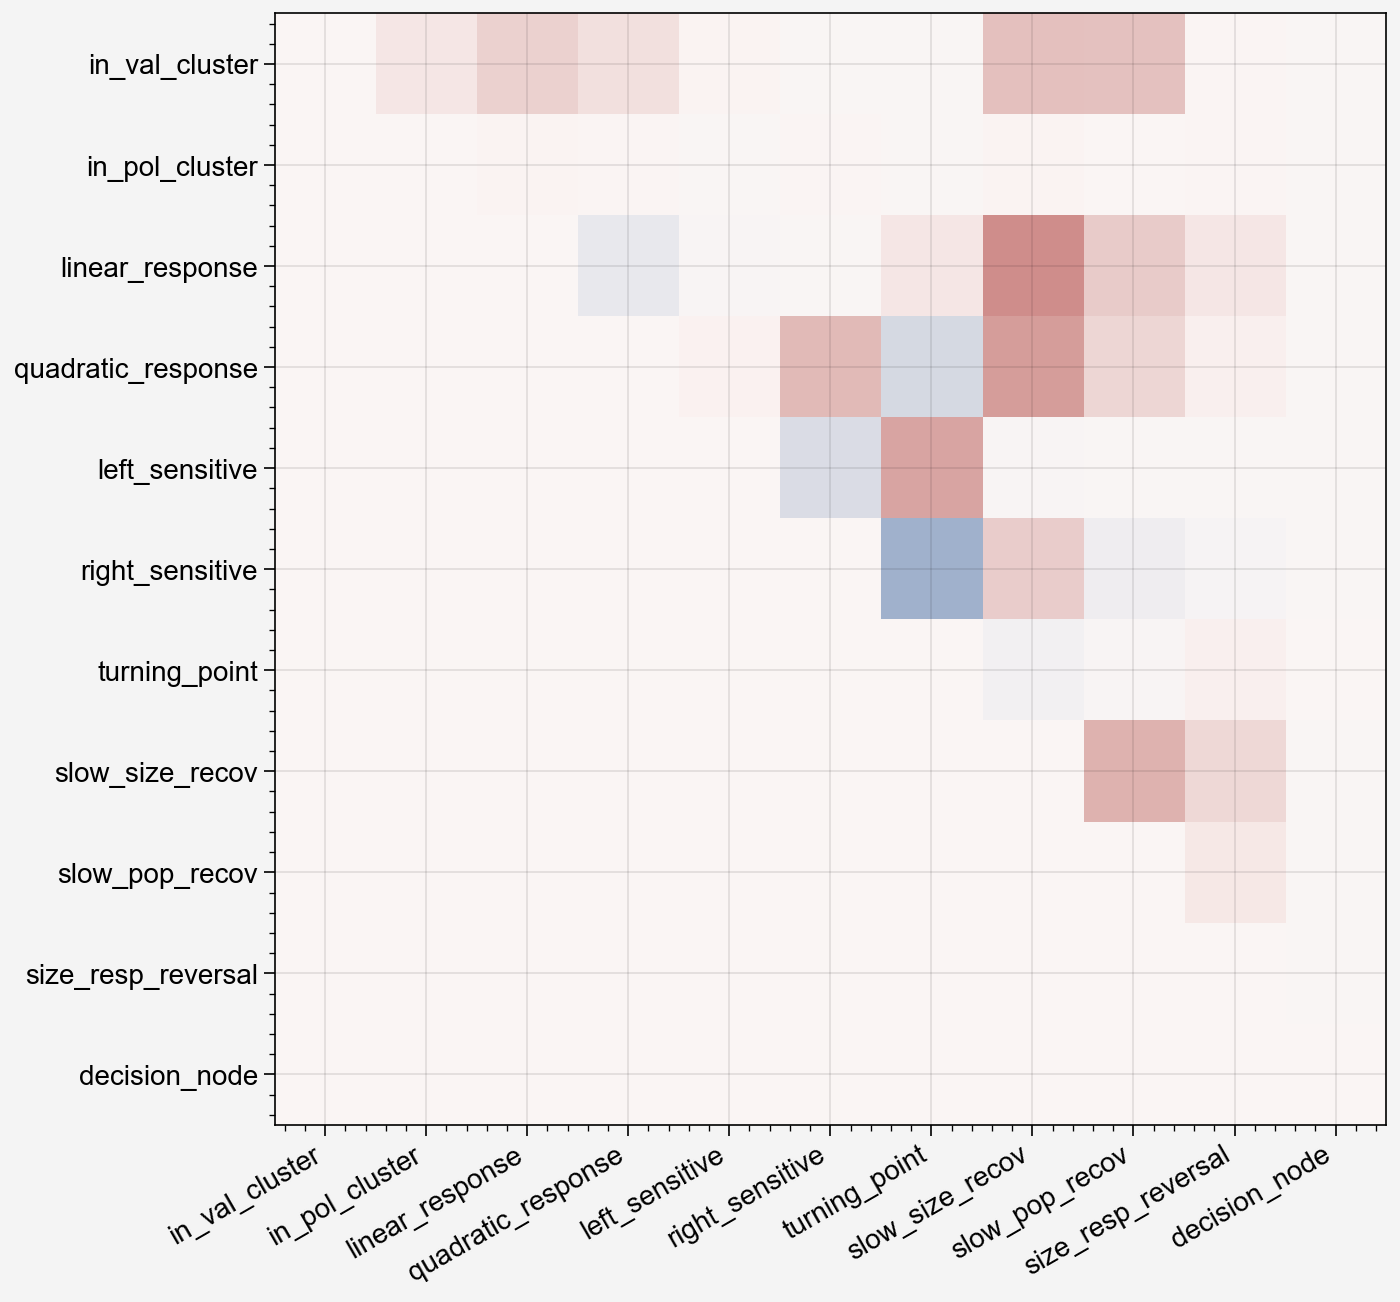

In [70]:
from scipy.stats import pearsonr
pearsonr(x, y)

n = len(node_keys)
total = 11520

corr = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i >= j:
            continue
        x = summary[node_keys[i]].reshape(-1)
        y = summary[node_keys[j]].reshape(-1)
        corr[i, j] = pearsonr(x, y).statistic
fig, ax = pplt.subplots(figwidth=7)
ax.imshow(corr, cmap='vlag', vmin=-1, vmax=1)
ax.format(ylocator=range(len(node_keys)), yformatter=node_keys,
          xlocator=range(len(node_keys)), xformatter=list(node_keys),
          xrotation=30)

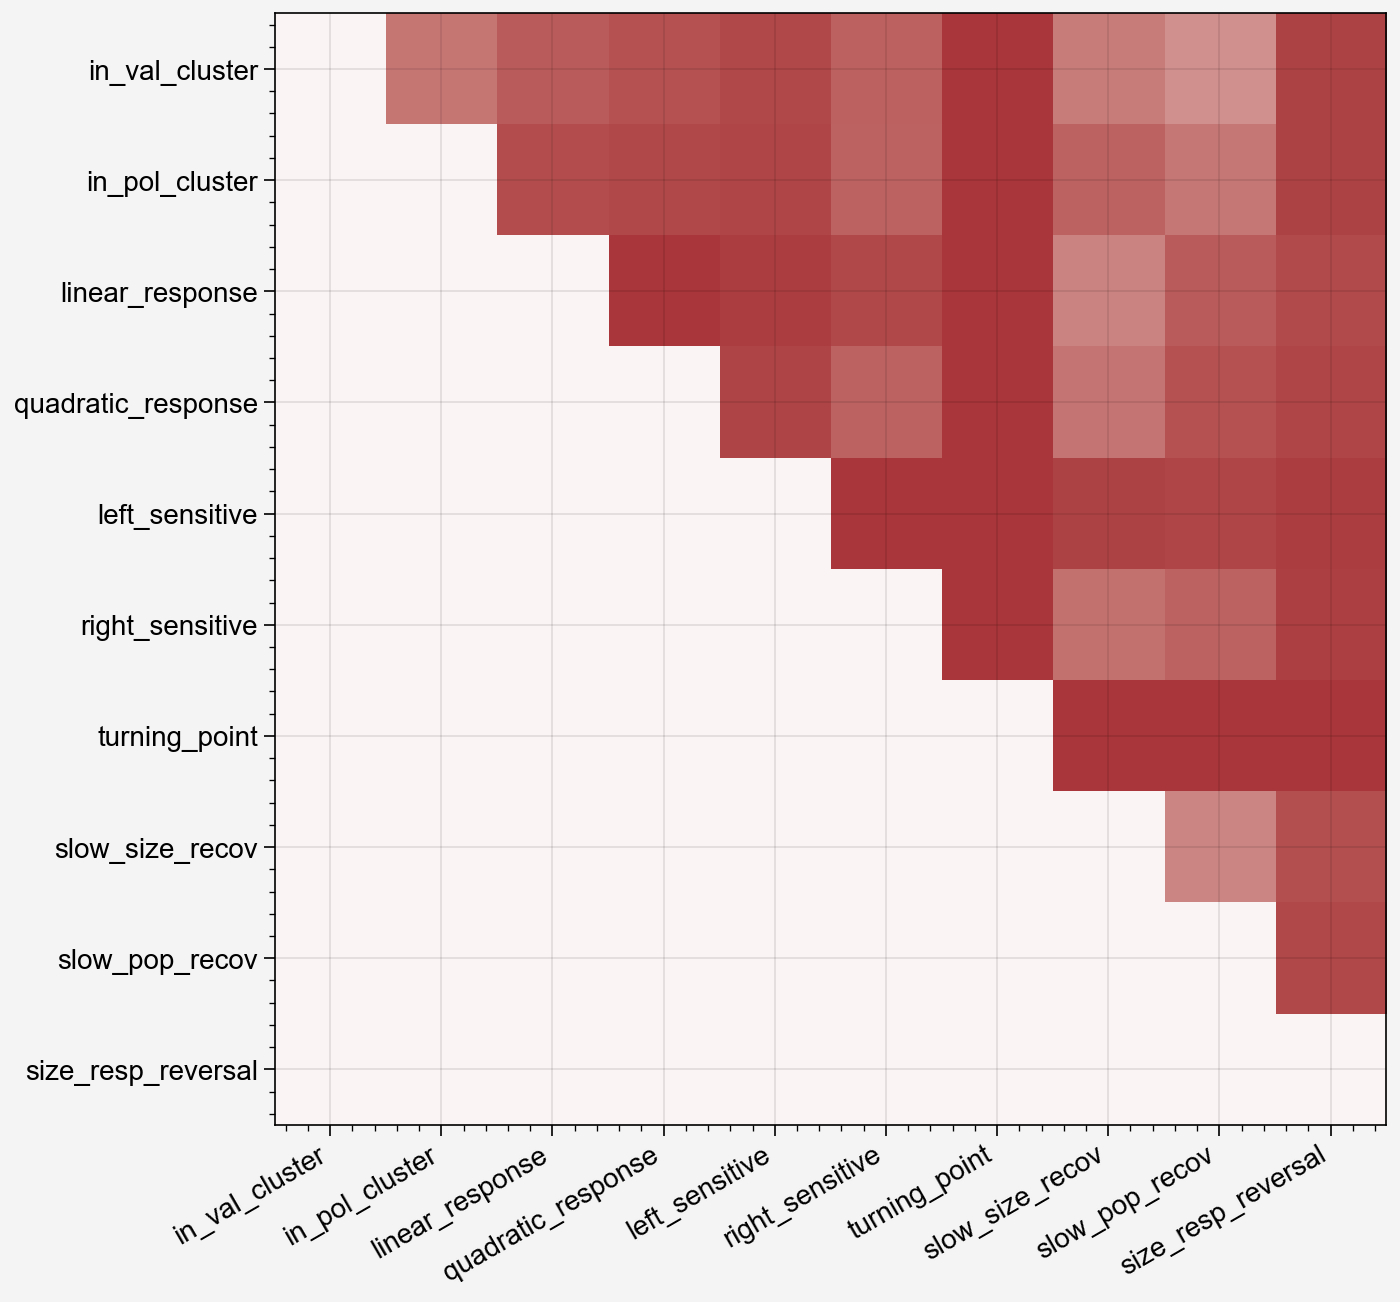

In [53]:
from scipy.spatial.distance import jaccard

n = len(node_keys)
total = 11520

corr = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i >= j:
            continue
        x = summary[node_keys[i]].reshape(-1)
        y = summary[node_keys[j]].reshape(-1)
        corr[i, j] = jaccard(x, y)
fig, ax = pplt.subplots(figwidth=7)
ax.imshow(corr, cmap='vlag', vmin=-1, vmax=1)
ax.format(ylocator=range(len(node_keys)), yformatter=node_keys,
          xlocator=range(len(node_keys)), xformatter=list(node_keys),
          xrotation=30)

c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


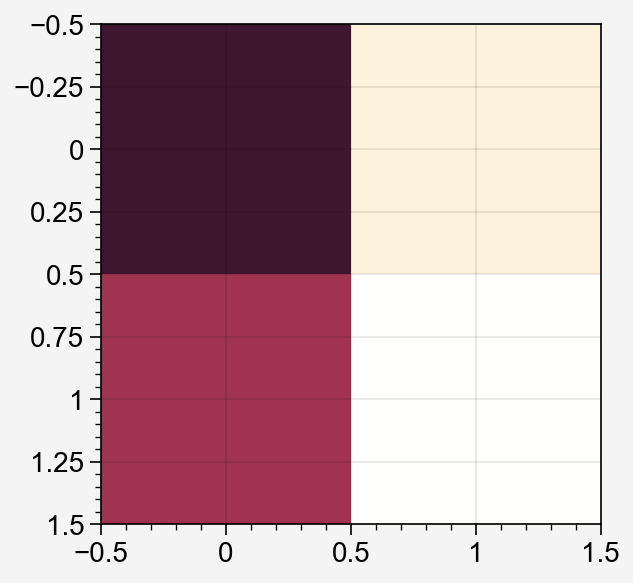

In [73]:
x, y = summary['in_pol_cluster'].reshape(-1), summary['decision_node'].reshape(-1)
cont = pd.crosstab(x, y)
fig, ax = pplt.subplots()
ax.imshow(cont)

0.1870366314629765


c:\Users\14and\anaconda3\envs\bart\lib\site-packages\numpy\ma\core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


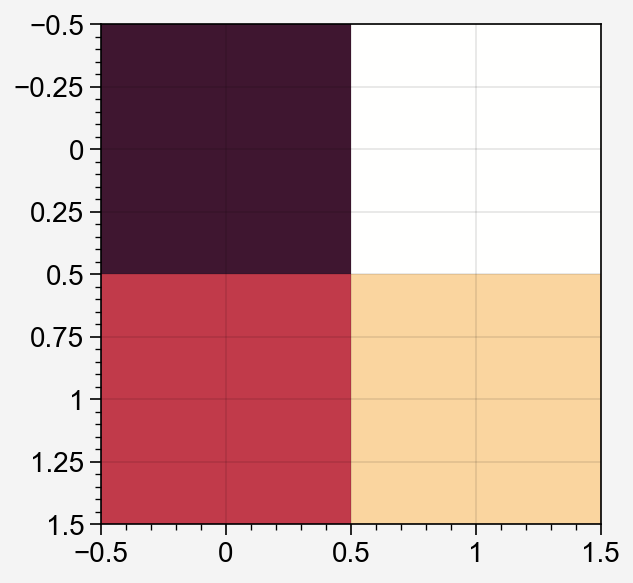

In [52]:
x, y = summary['bimodal_rnn'].reshape(-1), summary['bimodal_its'].reshape(-1)
cont = pd.crosstab(x, y)
fig, ax = pplt.subplots()
ax.imshow(cont)
corr = pearsonr(x, y).statistic
print(corr)

# Exploration Strategies and long-term nodes

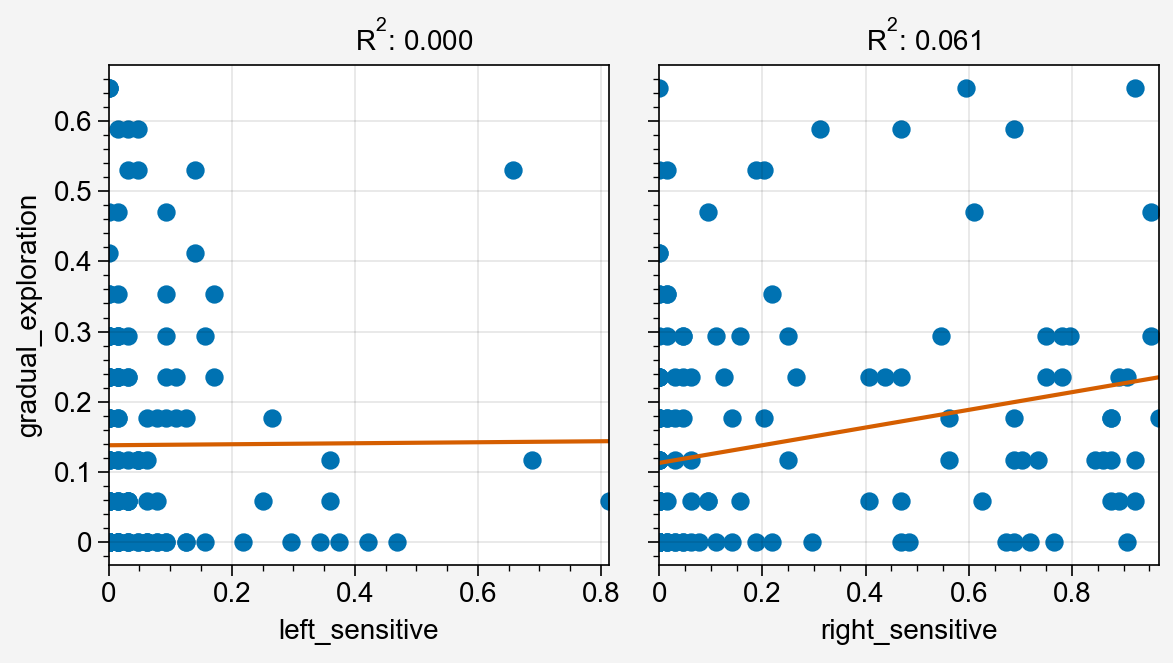

In [156]:
x_keys = ['left_sensitive', 'right_sensitive']
y_key = 'gradual_exploration'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.7, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

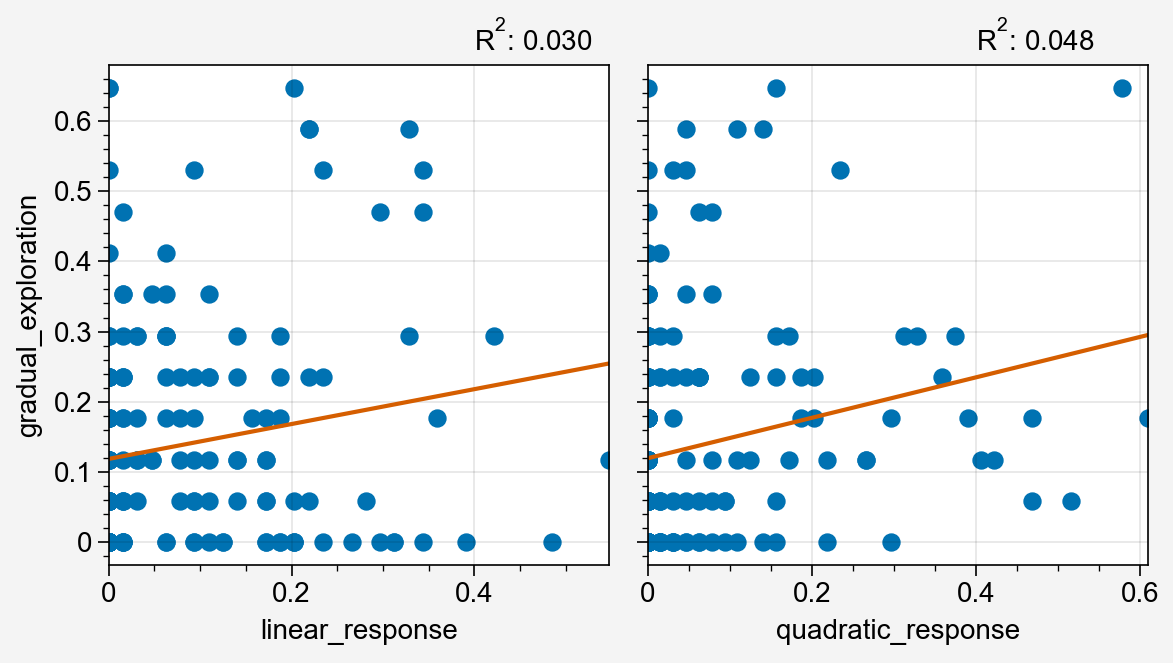

In [159]:
x_keys = ['linear_response', 'quadratic_response']
y_key = 'gradual_exploration'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.7, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

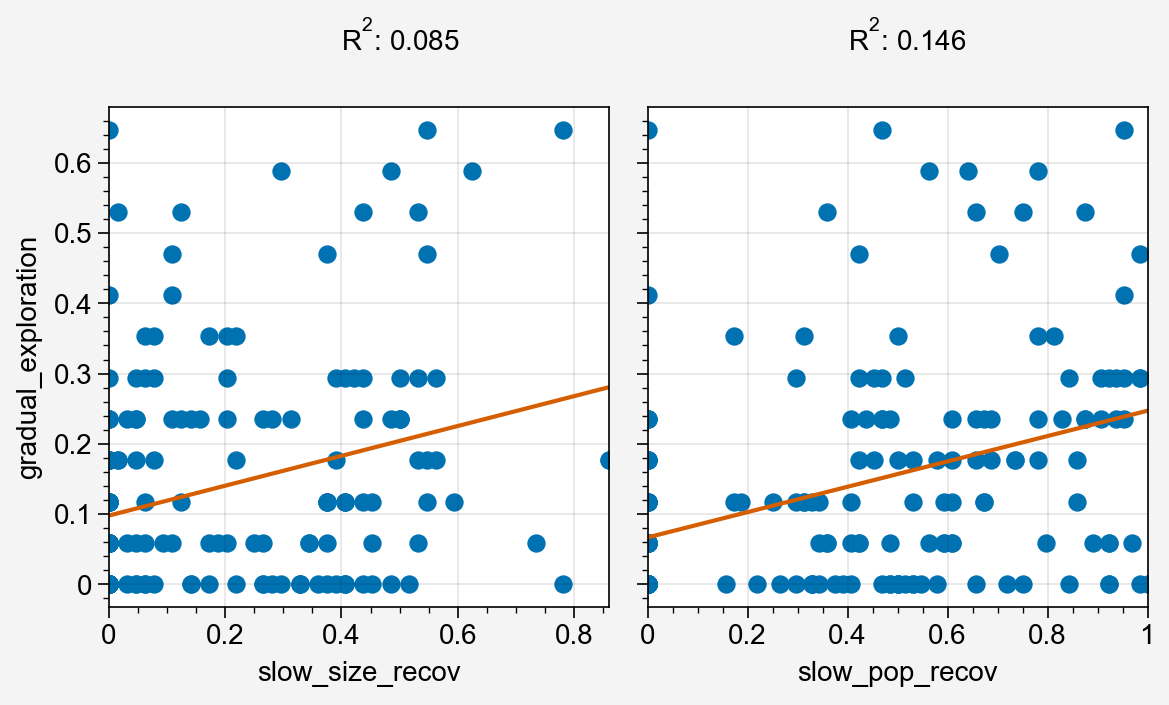

In [157]:
x_keys = ['slow_size_recov', 'slow_pop_recov']
y_key = 'gradual_exploration'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    
    # y = y[x > 0]
    # x = x[x > 0]
    
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.76, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

## Behavioral correlations

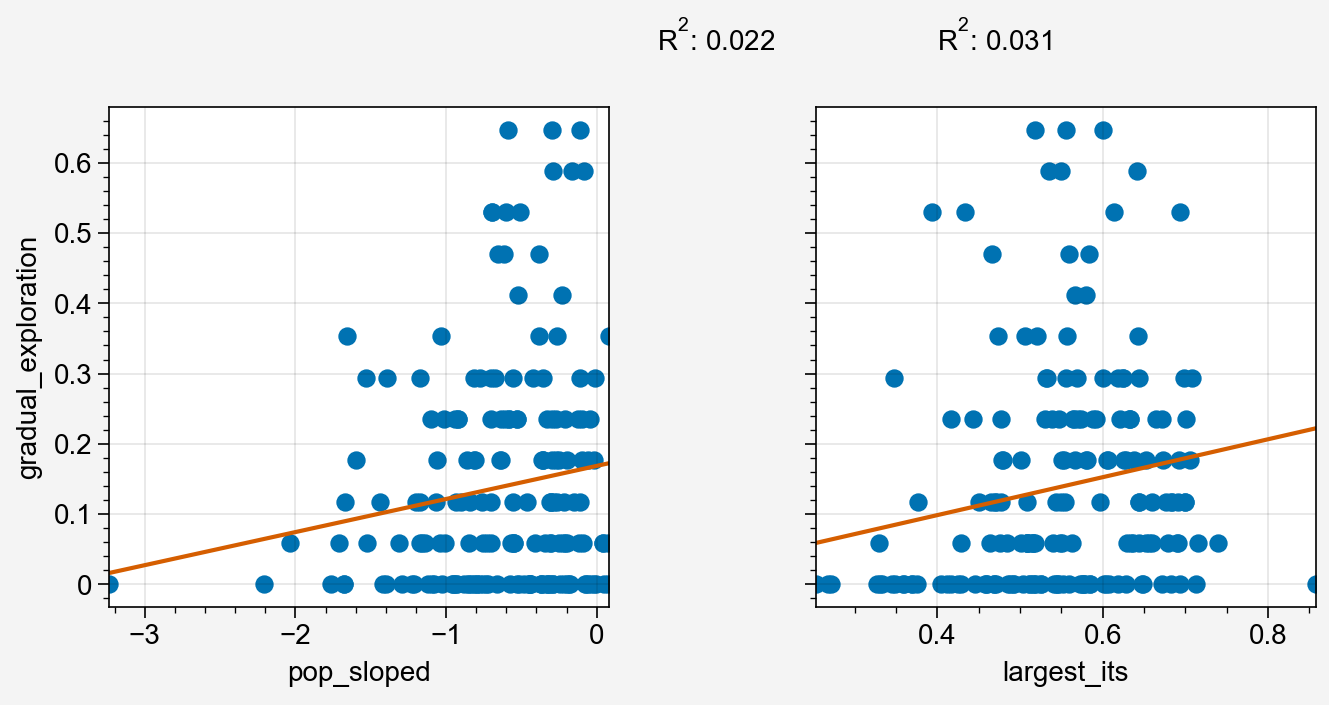

In [160]:
x_keys = ['pop_sloped', 'largest_its']
y_key = 'gradual_exploration'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].reshape(-1)
    y = summary[y_key].reshape(-1)
    
    # y = y[x > 0]
    # x = x[x > 0]
    
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.76, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

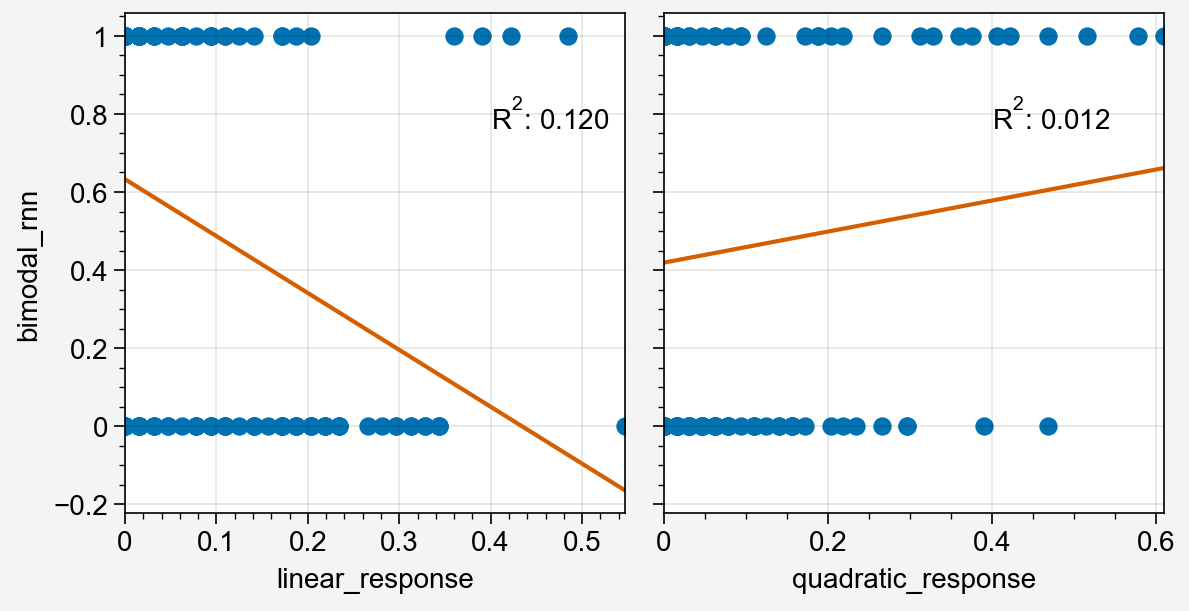

In [14]:
x_keys = ['linear_response', 'quadratic_response']
y_key = 'bimodal_rnn'
fig, ax = pplt.subplots(ncols=2, sharex=False)

for i, x_key in enumerate(x_keys):
    x = summary[x_key].mean(axis=4).reshape(-1)
    y = summary[y_key].reshape(-1)
    
    # y = y[x > 0]
    # x = x[x > 0]
    
    (m, b), r2 = linear_best_fit(x, y)
    
    ax[i].scatter(x, y)
    x = np.array([x.min(), x.max()])
    ax[i].plot(x, m*x+b)
    ax[i].text(0.4, 0.76, f'$R^2$: {r2:.3f}')
    ax[i].format(xlabel=x_key, ylabel=y_key)

# Agent clustering by meta cluster makeup


It looks like there are some distinct groups of types of agents based on the meta clusters makeup that they have, let's perform some KMeans to figure out how many distinct groupings there are

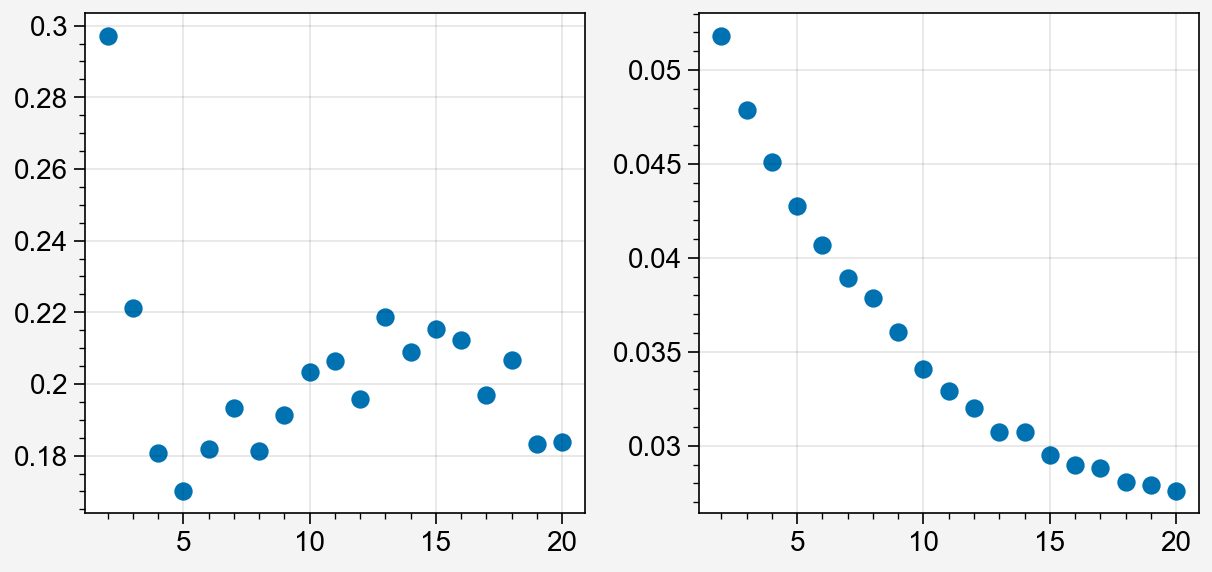

In [23]:
k = 6
idxs = select_chks_by_dimension(i=range(4))
labels = np.zeros(shape + (k,))
for idx in idxs:
    for c in range(k):
        labels[idx][c] = (np.array(forced_ares['agent_node_meta_labels'][idx]) == c).sum() / 64
clusters = labels.reshape(-1, k)

max_k = 20  # Maximum number of clusters to try
silhouette_scores = []
dists = []
ks = range(2, max_k + 1)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(clusters)
    silhouette_avg = silhouette_score(clusters, labels)
    silhouette_scores.append(silhouette_avg)
    dists.append(np.abs(clusters - kmeans.cluster_centers_[labels]).mean())
fig, ax = pplt.subplots(ncols=2, sharey=False)
ax[0].scatter(np.arange(2, 21), silhouette_scores)
ax[1].scatter(np.arange(2, 21), dists)

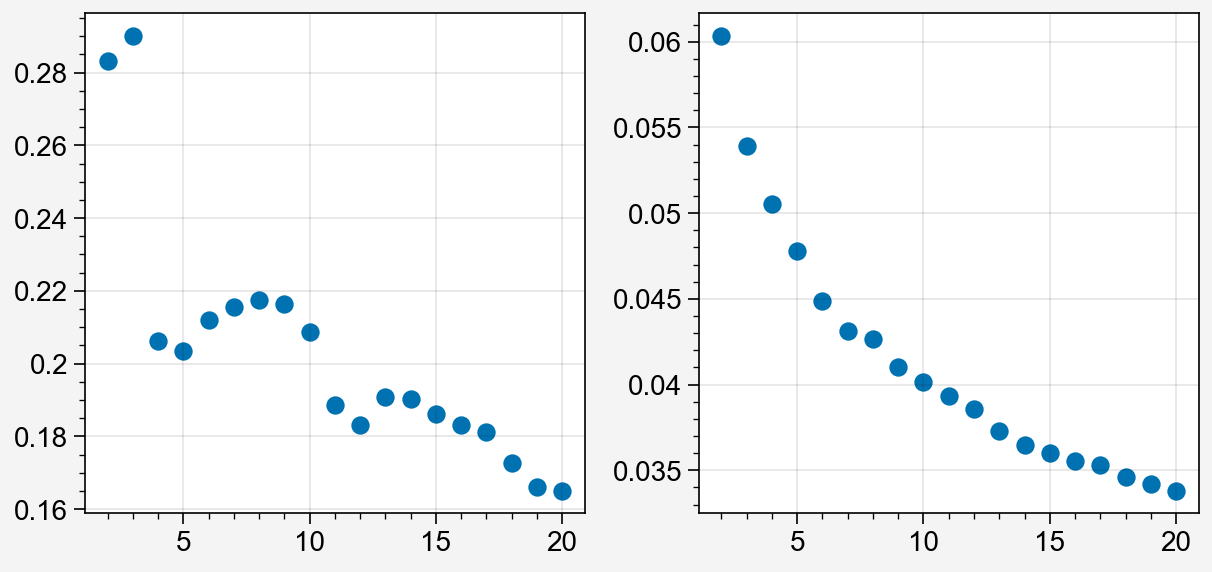

In [43]:
k = 6
idxs = select_chks_by_dimension(i=range(4))
labels = np.zeros(shape + (k,))
for idx in idxs:
    for c in range(k):
        labels[idx][c] = (np.array(forced_ares['agent_node_meta_labels'][idx]) == c).sum() / 64
clusters = labels.reshape(-1, k)

max_k = 20  # Maximum number of clusters to try
silhouette_scores = []
dists = []
ks = range(2, max_k + 1)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(clusters)
    silhouette_avg = silhouette_score(clusters, labels)
    silhouette_scores.append(silhouette_avg)
    dists.append(np.abs(clusters - kmeans.cluster_centers_[labels]).mean())
fig, ax = pplt.subplots(ncols=2, sharey=False)
ax[0].scatter(np.arange(2, 21), silhouette_scores)
ax[1].scatter(np.arange(2, 21), dists)

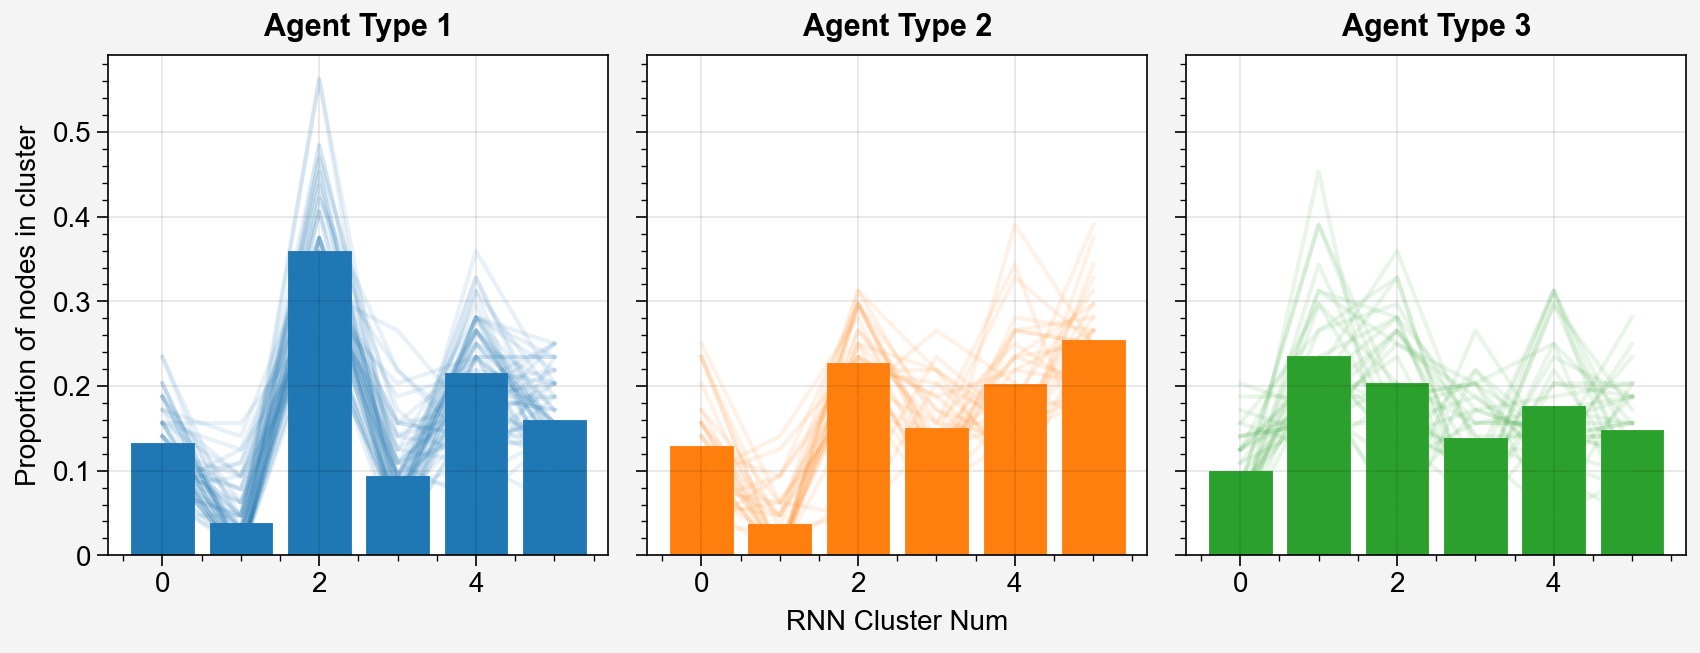

In [24]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
agent_labels = kmeans.fit_predict(clusters)
fig, ax = pplt.subplots(ncols=k)
for i in range(k):
    ax[i].bar(np.arange(6), kmeans.cluster_centers_[i], c=rgb_colors[i])
    tgts = np.argwhere(agent_labels == i).reshape(-1)
    for tgt in tgts:
        ax[i].plot(np.arange(6), clusters[tgt], c=rgb_colors[i], alpha=0.1)

ax.format(xlabel='RNN Cluster Num', ylabel='Proportion of nodes in cluster',
          toplabels=[f'Agent Type {n}' for n in range(1, 4)])

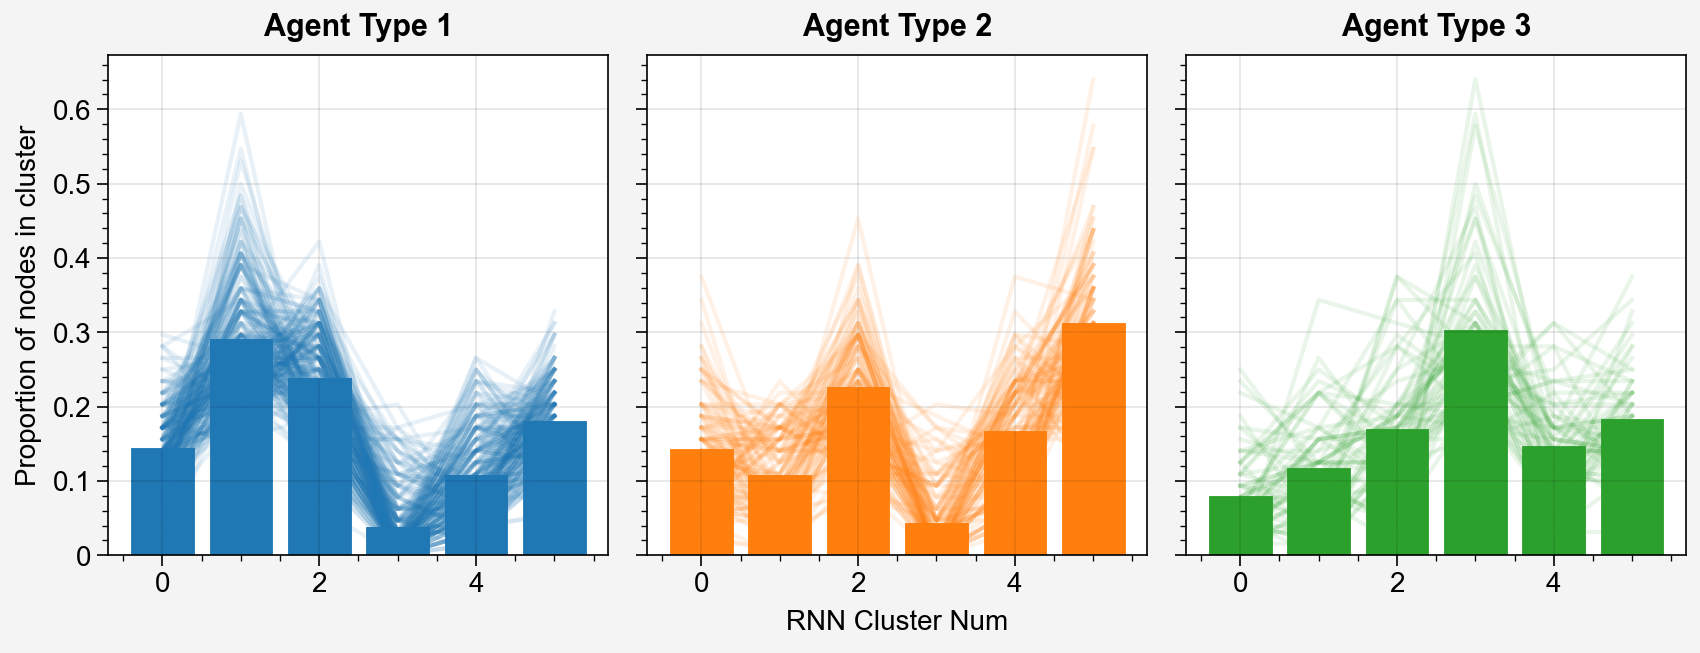

In [44]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
agent_labels = kmeans.fit_predict(clusters)
fig, ax = pplt.subplots(ncols=k)
for i in range(k):
    ax[i].bar(np.arange(6), kmeans.cluster_centers_[i], c=rgb_colors[i])
    tgts = np.argwhere(agent_labels == i).reshape(-1)
    for tgt in tgts:
        ax[i].plot(np.arange(6), clusters[tgt], c=rgb_colors[i], alpha=0.1)

ax.format(xlabel='RNN Cluster Num', ylabel='Proportion of nodes in cluster',
          toplabels=[f'Agent Type {n}' for n in range(1, 4)])

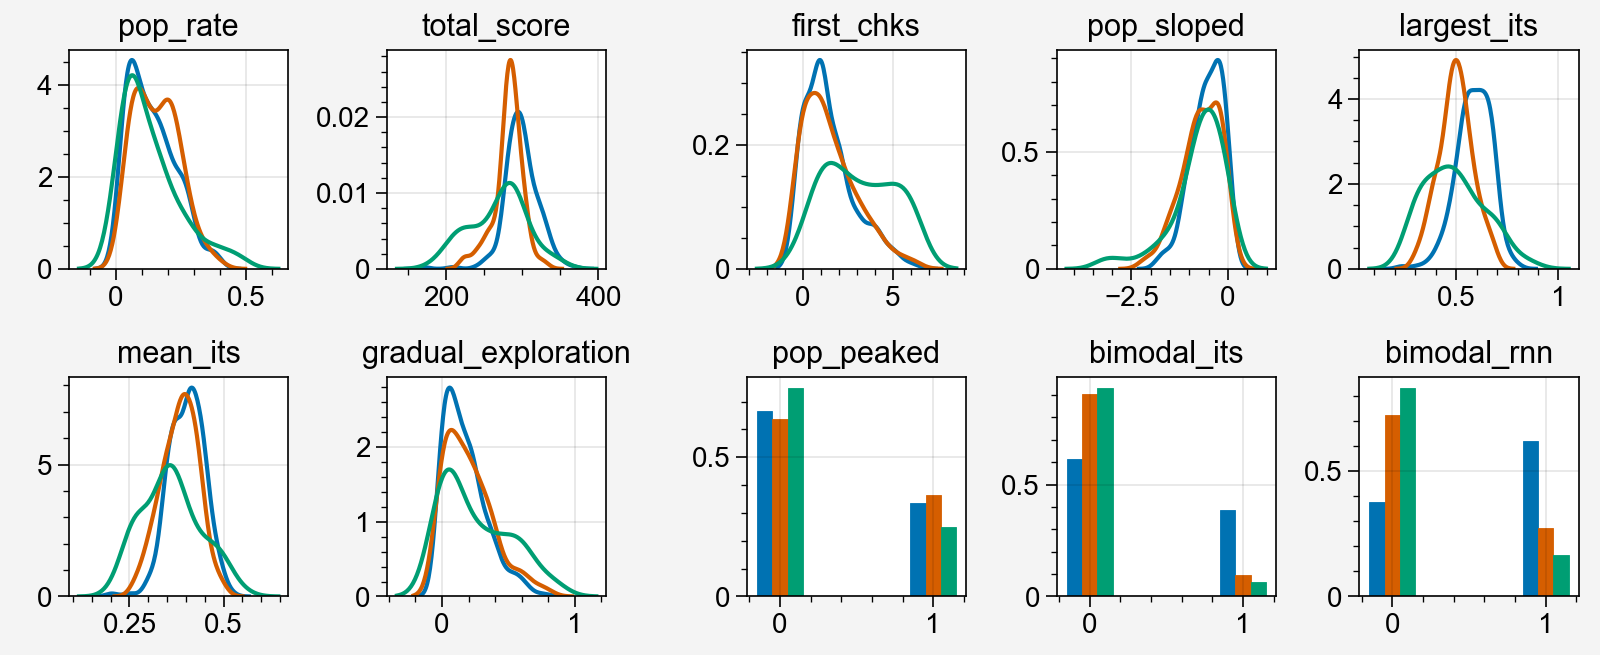

In [46]:
cont_agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
               'largest_its', 'mean_its', 'gradual_exploration']
bin_agent_keys = ['pop_peaked', 'bimodal_its', 'bimodal_rnn']

fig, ax = pplt.subplots(nrows=2, ncols=5, figwidth=8, sharex=False, sharey=False)
cur = 0
for key in cont_agent_keys:
    y = summary[key].reshape(-1)
    for i in range(k):
        sns.kdeplot(y[agent_labels == i], ax=ax[cur])
    ax[cur].format(title=key)
    cur += 1

agent_label_counts = [(agent_labels == i).sum() for i in range(k)]
for key in bin_agent_keys:
    y = summary[key].reshape(-1)
    ys = [y[agent_labels == i] for i in range(k)]
    ys = np.array([[(y == 0).sum(), (y == 1).sum()] for y in ys]).T
    ys = ys / np.array(agent_label_counts)
    ax[cur].bar(np.arange(2), ys, width=0.3)
    ax[cur].format(title=key)
    cur += 1

ax.format(ylabel='')

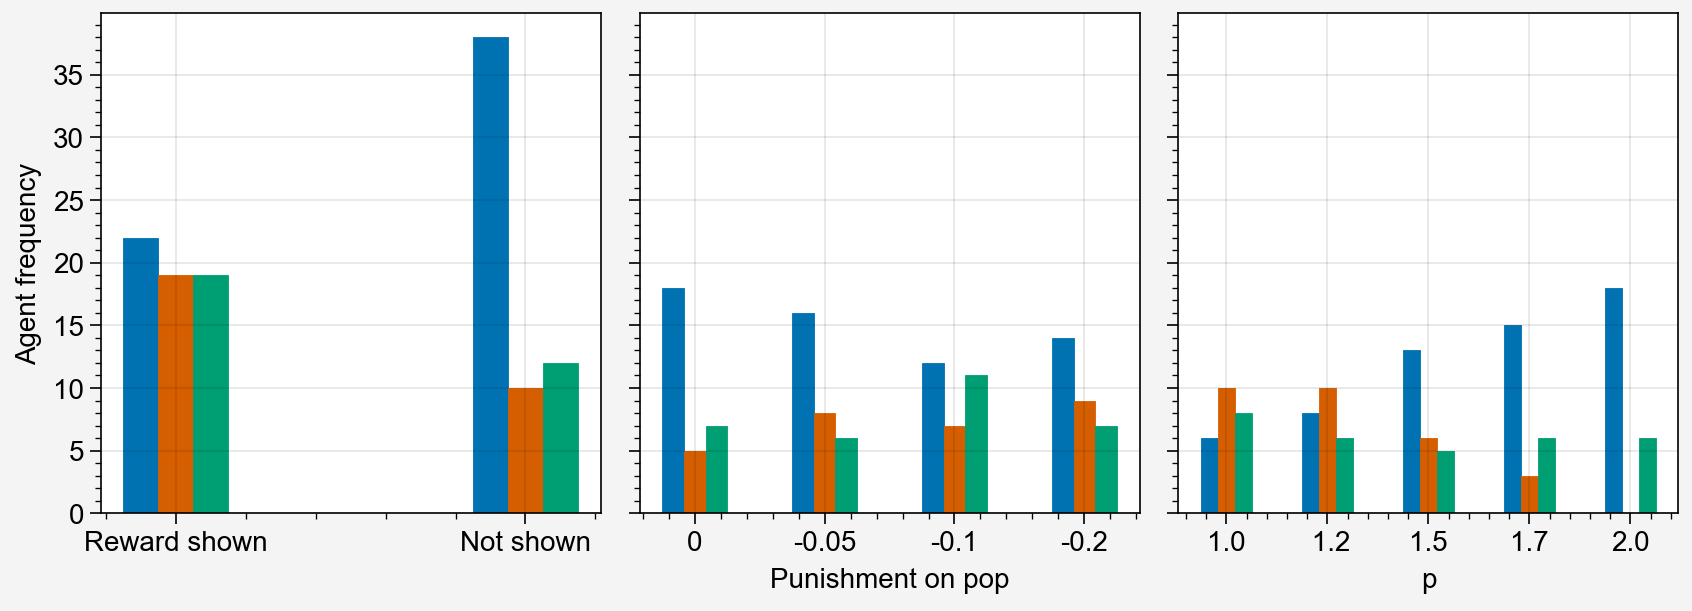

In [30]:
fig, ax = pplt.subplots(ncols=3, sharex=False)
label_counts = []
for h in range(2):
    idxs = select_chks_by_dimension(h=h, i=range(4), with_chk=False)
    shaped_labels = agent_labels.reshape(shape)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[0].bar(np.arange(2), label_counts, width=0.3)

label_counts = []
for i in range(4):
    idxs = select_chks_by_dimension(i=i, with_chk=False)
    shaped_labels = agent_labels.reshape(shape)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[1].bar(np.arange(4), label_counts, width=0.5)
    
label_counts = []
for j in range(5):
    idxs = select_chks_by_dimension(j=j, i=range(4), with_chk=False)
    shaped_labels = agent_labels.reshape(shape)
    l = np.array([shaped_labels[l] for l in idxs])
    l = [(l == i).sum() for i in range(k)]
    label_counts.append(l)
ax[2].bar(np.arange(5), label_counts, width=0.5)

    
ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Agent frequency')
ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)


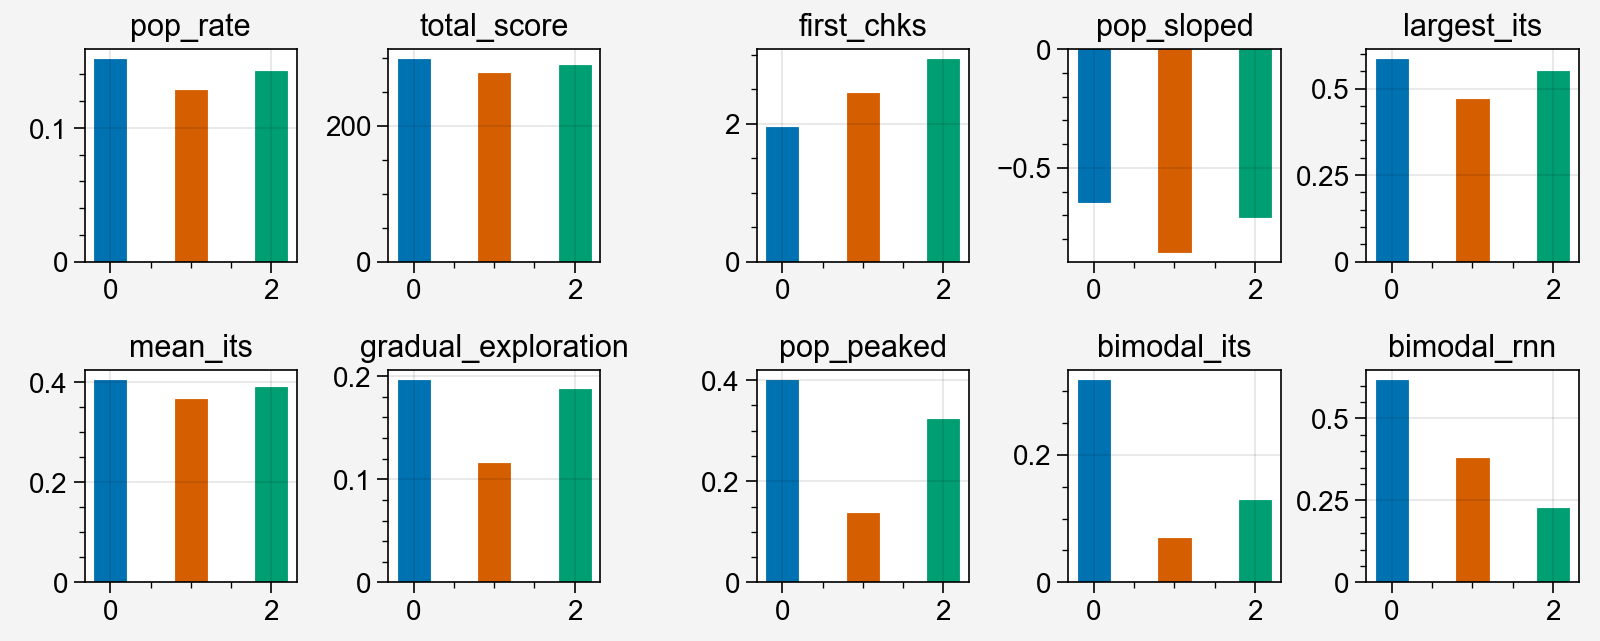

In [44]:
cont_agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
               'largest_its', 'mean_its', 'gradual_exploration']
bin_agent_keys = ['pop_peaked', 'bimodal_its', 'bimodal_rnn']

fig, ax = pplt.subplots(nrows=2, ncols=5, figwidth=8, sharex=False, sharey=False)
cur = 0
for key in cont_agent_keys:
    y = summary[key].reshape(-1)
    for i in range(k):
        ax[cur].bar(i, y[agent_labels == i].mean())
    ax[cur].format(title=key)
    cur += 1

agent_label_counts = [(agent_labels == i).sum() for i in range(k)]
for key in bin_agent_keys:
    y = summary[key].reshape(-1)
    ys = [np.mean(y[agent_labels == i]) for i in range(k)]
    # ys = np.array([[(y == 0).sum(), (y == 1).sum()] for y in ys]).T
    # ys = ys / np.array(agent_label_counts)
    for i in range(k):
        ax[cur].bar(i, ys[i])
    ax[cur].format(title=key)
    cur += 1

ax.format(ylabel='')

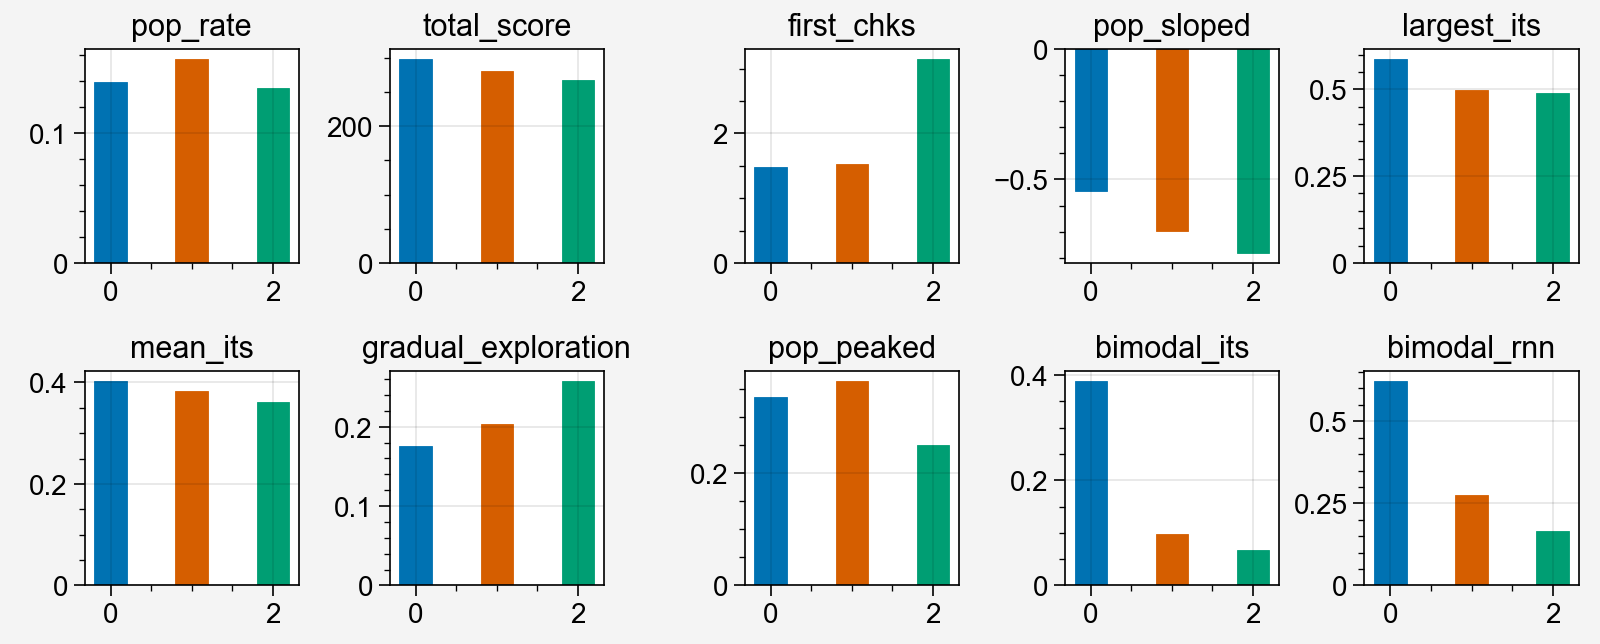

In [47]:
cont_agent_keys = ['pop_rate', 'total_score', 'first_chks', 'pop_sloped',
               'largest_its', 'mean_its', 'gradual_exploration']
bin_agent_keys = ['pop_peaked', 'bimodal_its', 'bimodal_rnn']

fig, ax = pplt.subplots(nrows=2, ncols=5, figwidth=8, sharex=False, sharey=False)
cur = 0
for key in cont_agent_keys:
    y = summary[key].reshape(-1)
    for i in range(k):
        ax[cur].bar(i, y[agent_labels == i].mean())
    ax[cur].format(title=key)
    cur += 1

agent_label_counts = [(agent_labels == i).sum() for i in range(k)]
for key in bin_agent_keys:
    y = summary[key].reshape(-1)
    ys = [np.mean(y[agent_labels == i]) for i in range(k)]
    # ys = np.array([[(y == 0).sum(), (y == 1).sum()] for y in ys]).T
    # ys = ys / np.array(agent_label_counts)
    for i in range(k):
        ax[cur].bar(i, ys[i])
    ax[cur].format(title=key)
    cur += 1

ax.format(ylabel='')

# Meta Cluster / Representation Connections

## Cluster Analysis

In [ ]:
kmeans = forced_ares['node_kmeans']
centers = kmeans.cluster_centers_

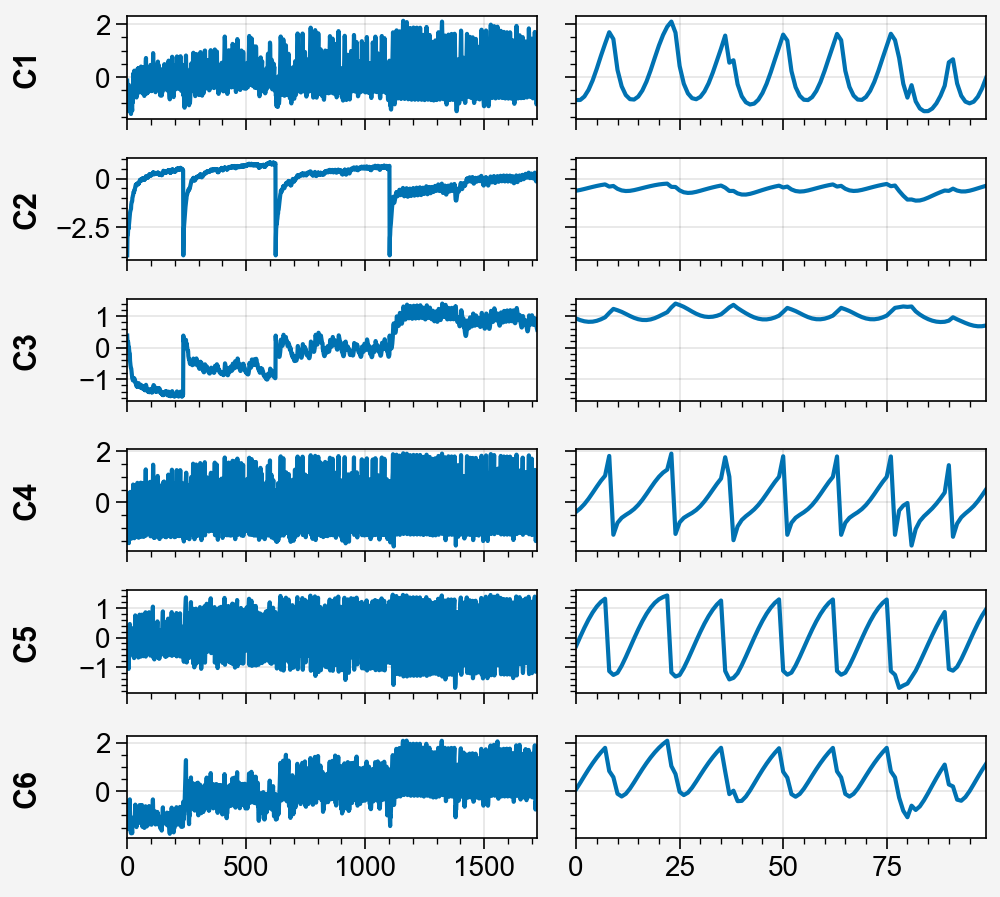

In [67]:
fig, ax = pplt.subplots(nrows=len(centers), ncols=2, refaspect=4, figwidth=5)
for i in range(len(centers)):
    # ax[i].plot(centers[i, 1300:1400])
    ax[i, 0].plot(centers[i])
    ax[i, 1].plot(centers[i, 1300:1400])
ax.format(leftlabels=[f'C{i}' for i in range(1, 7)])

## Individual Nodes as part of Clusters

Testing hypothesis that nodes with significant pop and size sensitivity tend to be found with C2-like activity

In [69]:
summary['size_resp_reversal'].shape

(2, 4, 5, 3, 64)

In [74]:
node_labels = np.zeros(shape + (64,))
for idx in idxs:
    node_labels[idx] = forced_ares['agent_node_meta_labels'][idx]

In [94]:
node_keys = [ #'val_scores', 'pol_scores', 
             'in_val_cluster', 'in_pol_cluster',
             'linear_response', 'quadratic_response', 'left_sensitive', 'right_sensitive', 
             'turning_point', 'slow_size_recov', 'slow_pop_recov', 'size_resp_reversal',
             'decision_node', 'bimodal_nodes']
len(node_keys)

12

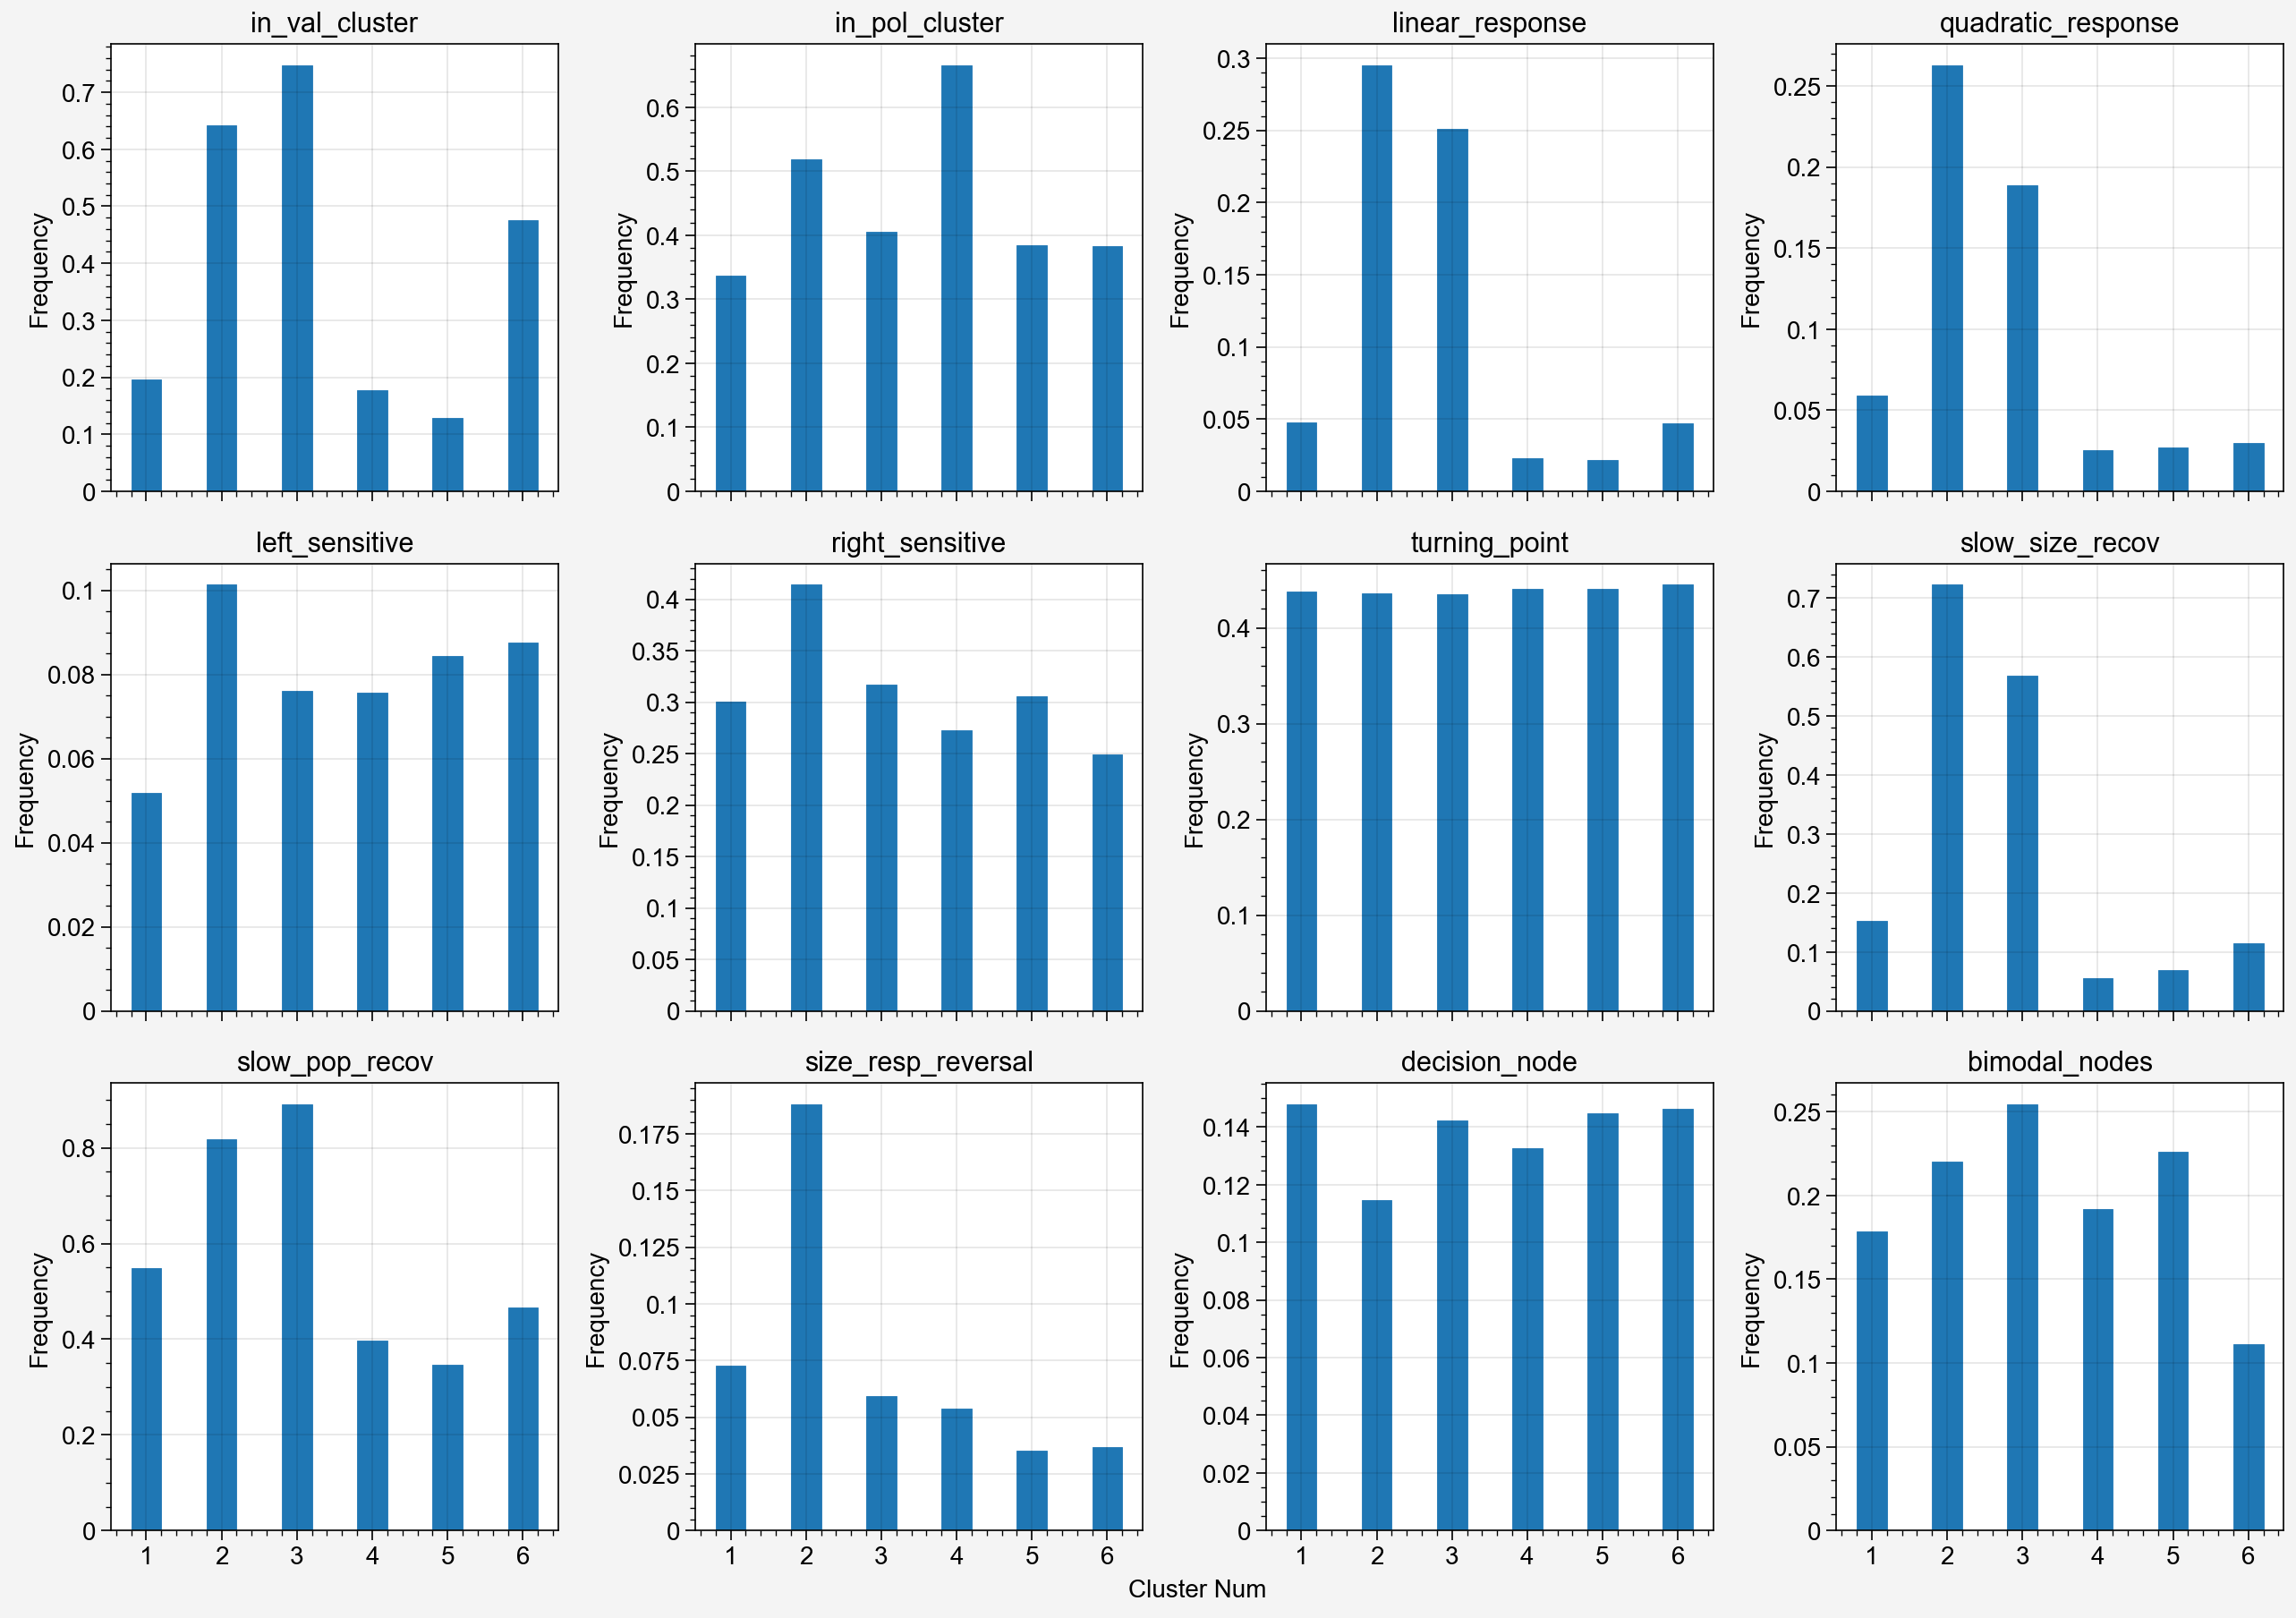

In [96]:
fig, ax = pplt.subplots(nrows=3, ncols=4, sharey=False)

k = 6
node_counts = [(node_labels == i).sum() for i in range(k)]

for m, key in enumerate(node_keys):
    for i in range(k):
        y = summary[key][node_labels == i].sum() / node_counts[i]
        ax[m].bar(i, y, c=rgb_colors[0])
    ax[m].format(title=key)

ax.format(xlabel='Cluster Num', xlocator=range(6), xformatter=[f'{i}' for i in range(1, 7)],
          ylabel='Frequency')